<a href="https://colab.research.google.com/github/ShovalBenjer/Bank-Change-Prediction/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Greetings!
> You received this jupyter notebook as we believe this can be a great fit. <br>
> The goal of this notebook is to understand our challenges better <br> and assess your proficiency in python & pandas.

### Several remarks:
* You are welcome to use the internet, consult, and use any available sources.
* There is no time limit, and we do not monitor any versioning or pace. Take your time and have fun.
* The notebook should take up to two hours. If it takes more than that, please reach out.
We tried to create an intriguing assignment. If you have any feedback - we'll be happy to hear.
* A text cell decorated with "👷" will be followed by a code cell you are welcome to fill in.

### **Make sure the notebook runs end to end before submission**

# **The products recommendation notebook**
The data at hand represents 12,000 bank clients and their monthly financial status.
<br> The data is featured as a tabular schema, where each row contains 48 features.
>The first 24 features are client-level entities such as age, residence country, and the joining channel.
<br>The last 24 features are the **products** the client owns in a specified month (`Status_Dt`).

Our task is to *forecast* which products a client will add or remove next month, given that we have all past information on the client.

TL;DR



# **TL;DR:**
TSMixer and TSMixerx outperformed MLPMultivariate in predicting 96 time steps, with lower errors (MAE: 0.250, MSE: 0.163). LightGBM achieved strong results for some targets (Precision: 0.827, Recall: 0.848, F1: 0.837) but struggled with sparse data. Optuna's hyperparameter tuning improved LightGBM's efficiency. Combining models like TSMixer and LightGBM could enhance performance, particularly for challenging or sparse data.











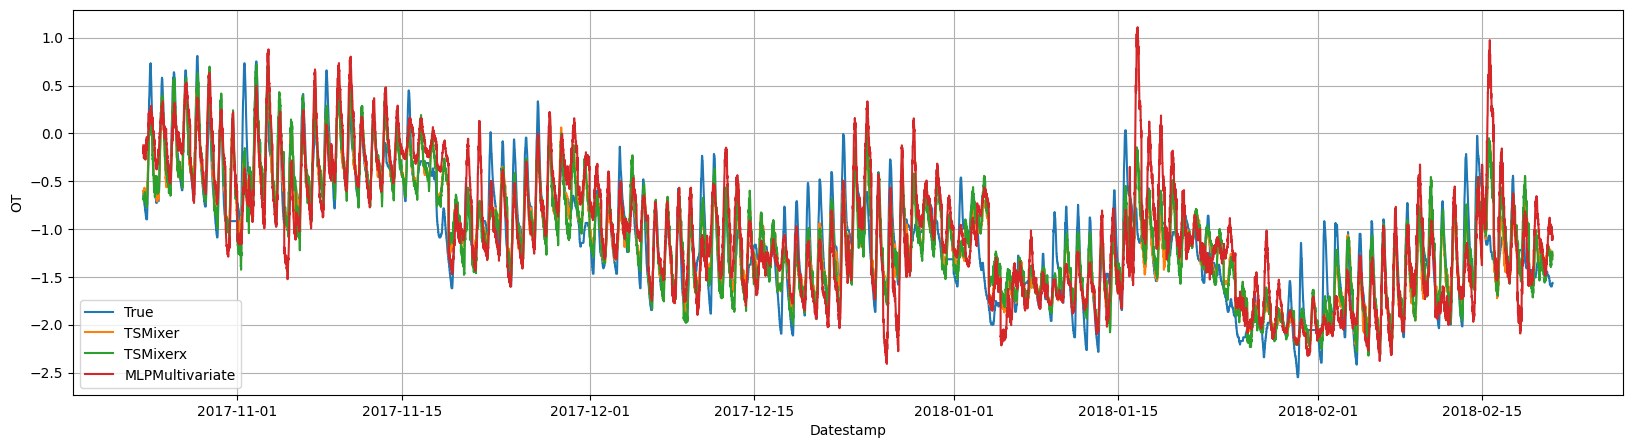

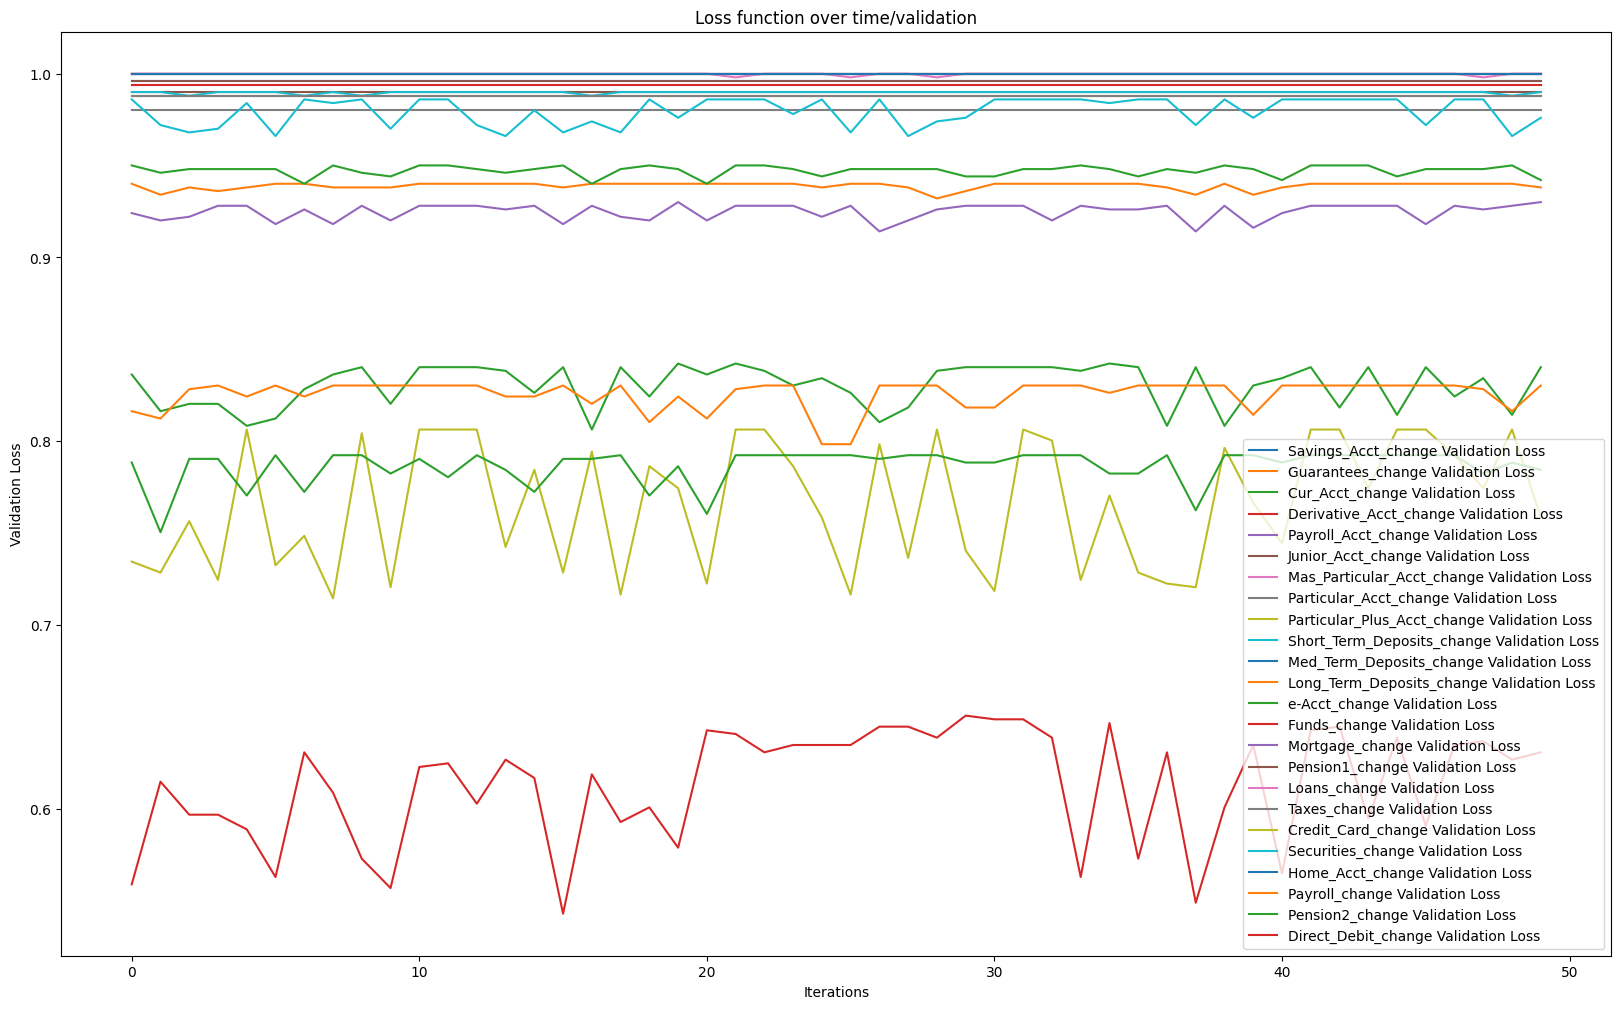

# Logistics

In [ ]:
# You will probably need to run this cell twice,
# as google colab has runtime issues after installing some libraries
# (press the "Restart runtime" button in the output cell)
!pip install --upgrade gdown

In [ ]:
# Download and extract the dataset
!rm -rf sample_data
!mkdir data & gdown 1DkOvf0LaRgCVfLEtHXr5ztaHhGN4-tDu -O data/features_products.zip
!unzip data/features_products.zip -d data/features_products
!find . -name "*.zip" ! -iname features_products.zip | while read filename; do unzip -o -d "`dirname "$filename"`" "$filename"; done;
!find . -name "*.zip" -delete

mkdir: cannot create directory ‘data’: File exists
Downloading...
From (original): https://drive.google.com/uc?id=1DkOvf0LaRgCVfLEtHXr5ztaHhGN4-tDu
From (redirected): https://drive.google.com/uc?id=1DkOvf0LaRgCVfLEtHXr5ztaHhGN4-tDu&confirm=t&uuid=770dda3e-eba1-4a69-9b2e-b88c2c21e347
To: /content/data/features_products.zip
100% 240M/240M [00:08<00:00, 29.7MB/s]
Archive:  data/features_products.zip
  inflating: data/features_products/sample_submission.csv.zip  
  inflating: data/features_products/test_ver2.csv.zip  
  inflating: data/features_products/train_ver2.csv.zip  
Archive:  ./longhorizon/datasets/datasets.zip
  inflating: ./longhorizon/datasets/ETTm2/df_y.csv  
  inflating: ./longhorizon/datasets/ETTm2/M/df_y.csv  
  inflating: ./longhorizon/datasets/ETTm2/M/df_x.csv  
  inflating: ./longhorizon/datasets/ETTm2/df_x.csv  
  inflating: ./longhorizon/datasets/ETTm2/S/df_y.csv  
  inflating: ./longhorizon/datasets/ETTm2/S/df_x.csv  
  inflating: ./longhorizon/datasets/weather/M/df_y.

In [ ]:
# Import libraries and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)
import warnings
warnings.filterwarnings("ignore")


Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Sample the dataset (We only want to experiment with the data).
limit_rows   = 7000000
df           = pd.read_csv("data/features_products/train_ver2.csv",dtype={"sexo":str,
                                                    "ind_nuevo":str,
                                                    "ult_fec_cli_1t":str,
                                                    "indext":str},
                                                     nrows=limit_rows)


In [ ]:
# The original schema was in Spanish. We will rename the columns for readability.
df.columns = ['Status_Dt', 'Cust_ID', 'Emp_Status', 'Cust_Ctry', 'Cust_Sex', 'Age', 'Join_Dt',
                'Is_New_Cust', 'Cust_Since', 'Relship_Status','Lst_Dt_Primary_Cust', 'Cust_Type_Mth_Beg',
                'Cust_Relship_Type_Mth_Beg', 'Residence_Ctry', 'Is_Foreigner', 'Is_Spouse_Emp', 'Join_Channel', 'Deceased_Flg',
                'Address_Type', 'Cust_Province_Cd', 'Cust_Province_Name', 'Cust_Active_Status', 'Gross_HHLD_Income',
                'Cust_Segment', 'Savings_Acct', 'Guarantees', 'Cur_Acct', 'Derivative_Acct', 'Payroll_Acct',
                'Junior_Acct', 'Mas_Particular_Acct', 'Particular_Acct', 'Particular_Plus_Acct', 'Short_Term_Deposits',
                'Med_Term_Deposits', 'Long_Term_Deposits', 'e-Acct', 'Funds', 'Mortgage', 'Pension1', 'Loans',
                'Taxes', 'Credit_Card', 'Securities', 'Home_Acct', 'Payroll', 'Pension2', 'Direct_Debit']

# Sample the dataset (We only want to experiment with the data).
unique_ids   = pd.Series(df["Cust_ID"].unique())
limit_people = int(1.2e4)
unique_id    = unique_ids.sample(n=limit_people)
df           = df[df.Cust_ID.isin(unique_id)]

In [ ]:
# Cast relevant data types
date_attribs = ['Status_Dt', 'Join_Dt', 'Lst_Dt_Primary_Cust']
for attrib in date_attribs:
    df[attrib] = pd.to_datetime(df[attrib],format="%Y-%m-%d")
numeric_attribs = ['Age', 'Is_New_Cust', 'Cust_Since', 'Relship_Status', 'Address_Type', 'Cust_Active_Status']
for attrib in numeric_attribs:
    df[attrib] = pd.to_numeric(df[attrib], downcast='integer',errors='coerce')

# **System Requirements**
Python version: 3.7+
Minimum RAM: 8GB (recommended 16GB or more for large datasets)
CPU: Multi-core CPU (recommended)
GPU: Optional but recommended for NeuralForecast models using TSMixer, NHITS, or other deep learning models.

# Installations Imports and Dependencies

In [ ]:
!pip install pandas numpy seaborn matplotlib xgboost shap-hypetune optuna lightgbm ray neuralforecast datasetsforecast statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from typing import Tuple

import lightgbm as lgb
from lightgbm import log_evaluation, record_evaluation
from xgboost import XGBClassifier
from shaphypetune import BoostRFE
import optuna

from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch

from neuralforecast.core import NeuralForecast
from neuralforecast.models import TSMixer, TSMixerx, NHITS, MLPMultivariate
from neuralforecast.auto import AutoTSMixer
from neuralforecast.losses.pytorch import MAE

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datasetsforecast.long_horizon import LongHorizon

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score

def convert_to_datetime(df: pd.DataFrame, datetime_columns: list) -> pd.DataFrame:
    for col in datetime_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

def add_lagged_features(df: pd.DataFrame, datetime_columns: list) -> pd.DataFrame:
    for col in datetime_columns:
        if col in df.columns:
            df[col + '_week'] = df[col].dt.isocalendar().week
            df[col + '_quarter'] = df[col].dt.quarter
            df[col + '_year'] = df[col].dt.year
    return df

def process_numeric_features(df: pd.DataFrame, numeric_columns: list) -> pd.DataFrame:
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(-1)
    return df

def process_categorical_features(df: pd.DataFrame, one_hot_columns: list, label_columns: list) -> pd.DataFrame:
    one_hot_encoded_df = pd.get_dummies(df[one_hot_columns], drop_first=True)
    for col in label_columns:
        if col in df.columns:
            df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    df = df.drop(columns=one_hot_columns)
    df = pd.concat([df, one_hot_encoded_df], axis=1)
    return df

def create_shifted_columns(df: pd.DataFrame, product_columns: list) -> pd.DataFrame:
    df_copy = df.sort_values(by=['Cust_ID', 'Status_Dt'])
    df_copy['Status_Dt_shifted'] = df_copy.groupby('Cust_ID')['Status_Dt'].shift(-1)

    for col in product_columns:
        df_copy[f'{col}_shifted'] = df_copy.groupby('Cust_ID')[col].shift(-1)
        df_copy[f'{col}_change'] = df_copy[f'{col}_shifted'] - df_copy[col]

    df_copy.fillna(0, inplace=True)
    return df_copy

def create_next_data_label(df: pd.DataFrame, product_columns: list) -> pd.DataFrame:
    df_copy = create_shifted_columns(df, product_columns)
    next_data_label = df_copy[['Cust_ID', 'Status_Dt', 'Status_Dt_shifted'] + [f'{col}_change' for col in product_columns]]
    return next_data_label

def plot_validation_results(evals_result_all: dict, target_columns: list) -> None:
    for target_col in target_columns:
        evals_result = evals_result_all[target_col]
        iterations = range(len(evals_result['valid_0']['multi_logloss']))

        plt.figure(figsize=(10, 6))
        plt.plot(iterations, evals_result['valid_0']['multi_logloss'], label=f'Validation Logloss ({target_col})')
        plt.xlabel('Iteration')
        plt.ylabel('Logloss')
        plt.title(f'Validation Logloss Over Time for {target_col}')
        plt.legend()
        plt.grid(True)
        plt.show()

def prepare_for_model(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    features = df.loc[:, ~df.columns.str.endswith('_change')].drop(['Cust_ID', 'Status_Dt'], axis=1)
    labels = df.loc[:, df.columns.str.endswith('_change')]

    features.loc[:, features.dtypes == 'object'] = features.loc[:, features.dtypes == 'object'].astype('category')

    features = features.drop(['Status_Dt_shifted_x', 'Status_Dt_shifted_y'], axis=1)

    for column in features.columns[features.dtypes == 'category']:
        features[column] = LabelEncoder().fit_transform(features[column])

    return features, labels

import pandas as pd

def shift_columns(df: pd.DataFrame, product_columns: list) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy['Status_Dt_shifted'] = df_copy.groupby('Cust_ID')['Status_Dt'].shift(-1)

    for col in product_columns:
        df_copy[f'{col}_shifted'] = df_copy.groupby('Cust_ID')[col].shift(-1)

    return df_copy

def calculate_product_changes(df: pd.DataFrame, product_columns: list) -> pd.DataFrame:
    for col in product_columns:
        df[f'{col}_change'] = df[f'{col}_shifted'] - df[col]

    return df

def create_next_data_label(df: pd.DataFrame, product_columns: list) -> pd.DataFrame:
    label_columns = ['Cust_ID', 'Status_Dt', 'Status_Dt_shifted'] + [f'{col}_change' for col in product_columns]
    next_data_label = df[label_columns]

    return next_data_label

def sanitize_feature_names(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    return df

def objective(trial: optuna.Trial, X_train: pd.DataFrame, y_train: pd.DataFrame,
              X_val: pd.DataFrame, y_val: pd.DataFrame, target_col: str) -> float:
    param = {
        'objective': 'multiclass',
        'num_class': 3,
        'boosting_type': 'gbdt',
        'metric': 'multi_logloss',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'verbose': -1
    }

    evals_result = {}
    lgb_train = lgb.Dataset(X_train, label=y_train[target_col])
    lgb_val = lgb.Dataset(X_val, label=y_val[target_col], reference=lgb_train)

    model = lgb.train(param, lgb_train, valid_sets=[lgb_val],
                      callbacks=[log_evaluation(0), record_evaluation(evals_result)])

    preds = model.predict(X_val)
    preds = np.argmax(preds, axis=1)
    score = accuracy_score(y_val[target_col], preds)

    return score

def plot_loss_function(evals_result_all):
    for target, evals_result in evals_result_all.items():
        plt.plot(evals_result['value'], label=f"{target} Validation Loss")

    plt.title('Loss function over time/validation')
    plt.xlabel('Iterations')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.show()

def plot_confusion_matrix_and_metrics(y_true, y_pred, target_col):
    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix for {target_col}:\n{cm}")
    print(f"Classification Report for {target_col}:\n{classification_report(y_true, y_pred)}")

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True, xticklabels=True, yticklabels=True)
    plt.title(f'Confusion Matrix for {target_col}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


# Exploratory Data Analysis 👷

### The task in this phase is to analyze the data.
#### Think of at least 3-5 useful EDA plots to present that helps understand the underlying statistics. Explain why you selected these plots. What insights/questions did you also find during the EDA?
*Remember - The goal is to predict which items customers will add in the following month.*

> You are not obligated to submit all plots and analyses you perform.
<br>Try to understand the data as good as possible.


# **Firstly - Cleaning And Encoding Analysis(EDA - Pre - Preprocess)**

> Add blockquote



* Categorical columns with missing values not missing at random were identified as needing specific handling, since these values likely reflect meaningful customer attributes or behaviors.
* Interpolation was chosen for numeric columns to maintain continuity in time-series data, filling gaps with estimated values based on neighboring data points.
* Missing join dates required differentiated handling for new and existing customers to avoid treating all missing values uniformly.

Questions:
* Should I treat missing values in columns like Deceased_Flg and Is_Spouse_Emp as actual categories, or are they simply incomplete data that should be discarded?
* How can I ensure that the choice of interpolation for numeric columns doesn’t introduce bias, particularly in a time-series context? (if i had more time i would try to check if the data has a clear trend or pattern over time. If the data fluctuates irregularly, simple linear interpolation may not be suitable, and more advanced methods like polynomial or spline interpolation could be used)

In [ ]:
print("Data types of columns in the DataFrame:")
print(df.dtypes)

Data types of columns in the DataFrame:
Status_Dt                    datetime64[ns]
Cust_ID                               int64
Emp_Status                           object
Cust_Ctry                            object
Cust_Sex                             object
Age                                 float64
Join_Dt                      datetime64[ns]
Is_New_Cust                         float64
Cust_Since                          float64
Relship_Status                      float64
Lst_Dt_Primary_Cust          datetime64[ns]
Cust_Type_Mth_Beg                    object
Cust_Relship_Type_Mth_Beg            object
Residence_Ctry                       object
Is_Foreigner                         object
Is_Spouse_Emp                        object
Join_Channel                         object
Deceased_Flg                         object
Address_Type                        float64
Cust_Province_Cd                    float64
Cust_Province_Name                   object
Cust_Active_Status                  

In [ ]:
categorical_columns = [
    'Emp_Status', 'Cust_Ctry', 'Cust_Sex', 'Cust_Type_Mth_Beg',
    'Cust_Relship_Type_Mth_Beg', 'Residence_Ctry', 'Is_Foreigner',
    'Is_Spouse_Emp', 'Join_Channel', 'Deceased_Flg',
    'Cust_Province_Name', 'Cust_Segment'
]

for col in categorical_columns:
    unique_values = df[col].unique()
    print(f"Column: {col}")
    print(f"Unique values: {unique_values}\n")

Column: Emp_Status
Unique values: ['N' nan 'B' 'A' 'F']

Column: Cust_Ctry
Unique values: ['ES' nan 'HN' 'IT' 'DE' 'AR' 'GB' 'FR' 'CU' 'US' 'CH' 'NL' 'RS' 'EC' 'BE'
 'MX' 'BR' 'VE' 'PT' 'RO' 'CZ' 'RU' 'GT' 'BO' 'CO' 'MA' 'CL' 'PE']

Column: Cust_Sex
Unique values: ['V' 'H' nan]

Column: Cust_Type_Mth_Beg
Unique values: [1.0 nan '1.0' '1' 'P' 3.0 '3' '3.0' '2.0' '4.0' 2.0]

Column: Cust_Relship_Type_Mth_Beg
Unique values: ['A' 'I' nan 'R' 'P']

Column: Residence_Ctry
Unique values: ['S' nan 'N']

Column: Is_Foreigner
Unique values: ['N' 'S' nan]

Column: Is_Spouse_Emp
Unique values: [nan 'N']

Column: Join_Channel
Unique values: ['KFC' 'KAT' 'KHE' 'KHD' 'KFA' 'KAZ' nan 'KEH' 'KAG' 'KAQ' 'KFJ' 'KGV'
 'KAI' 'KAA' 'KFG' 'RED' 'KFF' 'KAE' 'KAR' 'KGY' 'KFK' 'KFD' 'KCC' 'KAH'
 'KHC' 'KHK' 'KHF' 'KHL' 'KBG' 'KCL' 'KCK' 'KCG' 'KDR' 'KBU' 'KBZ' 'KEC'
 'KDV' 'KAY' 'KDC' 'KCB' '007' 'KAC' 'KBO' 'KAD' 'KBQ' 'KAS' 'KCM' 'KCN'
 'KBH' 'KBR' 'KBF' 'KBY' 'KCO' 'KAB' 'KDD' 'KBE' 'KDX' 'KAF' '013' 'KDU'
 

In [ ]:
# # Calculate the percentage of missing values per column
# missing_percentage = df.isnull().mean() * 100
# print(missing_percentage)

# **First Plot - AutoCorrelation Plot Partial and AutoCorrelation Plot of Cust_since**

* Partial Autocorrelation Plot: Shows the direct relationship between a time series point and its lagged values, removing the influence of intermediate lags.
* Autocorrelation Plot: Displays how a time series is related to its past values over time, helping to identify repeating patterns.
* The partial autocorrelation plot (PACF) indicates significant lags up to around 10, showing that Cust_Since has strong correlation with past values within a short time period.

* The autocorrelation plot (ACF) shows periodic fluctuations, suggesting cyclical or seasonal patterns.
* Next steps involve capturing these lagged dependencies by adding lagged features or using models that account for autocorrelation, such as ARIMA or LSTM, to improve predictive power.

* Question: How can the periodic fluctuations observed in the autocorrelation plot be leveraged to identify potential seasonal or cyclical patterns in customer tenure, and how might these patterns affect the predictive performance of time-series models such as LSTM or ARIMA? (I didn’t have time, but I thought including seasonal components or Fourier terms could capture the periodic fluctuations, improving models like SARIMA or LSTM for long-term trend forecasting.)










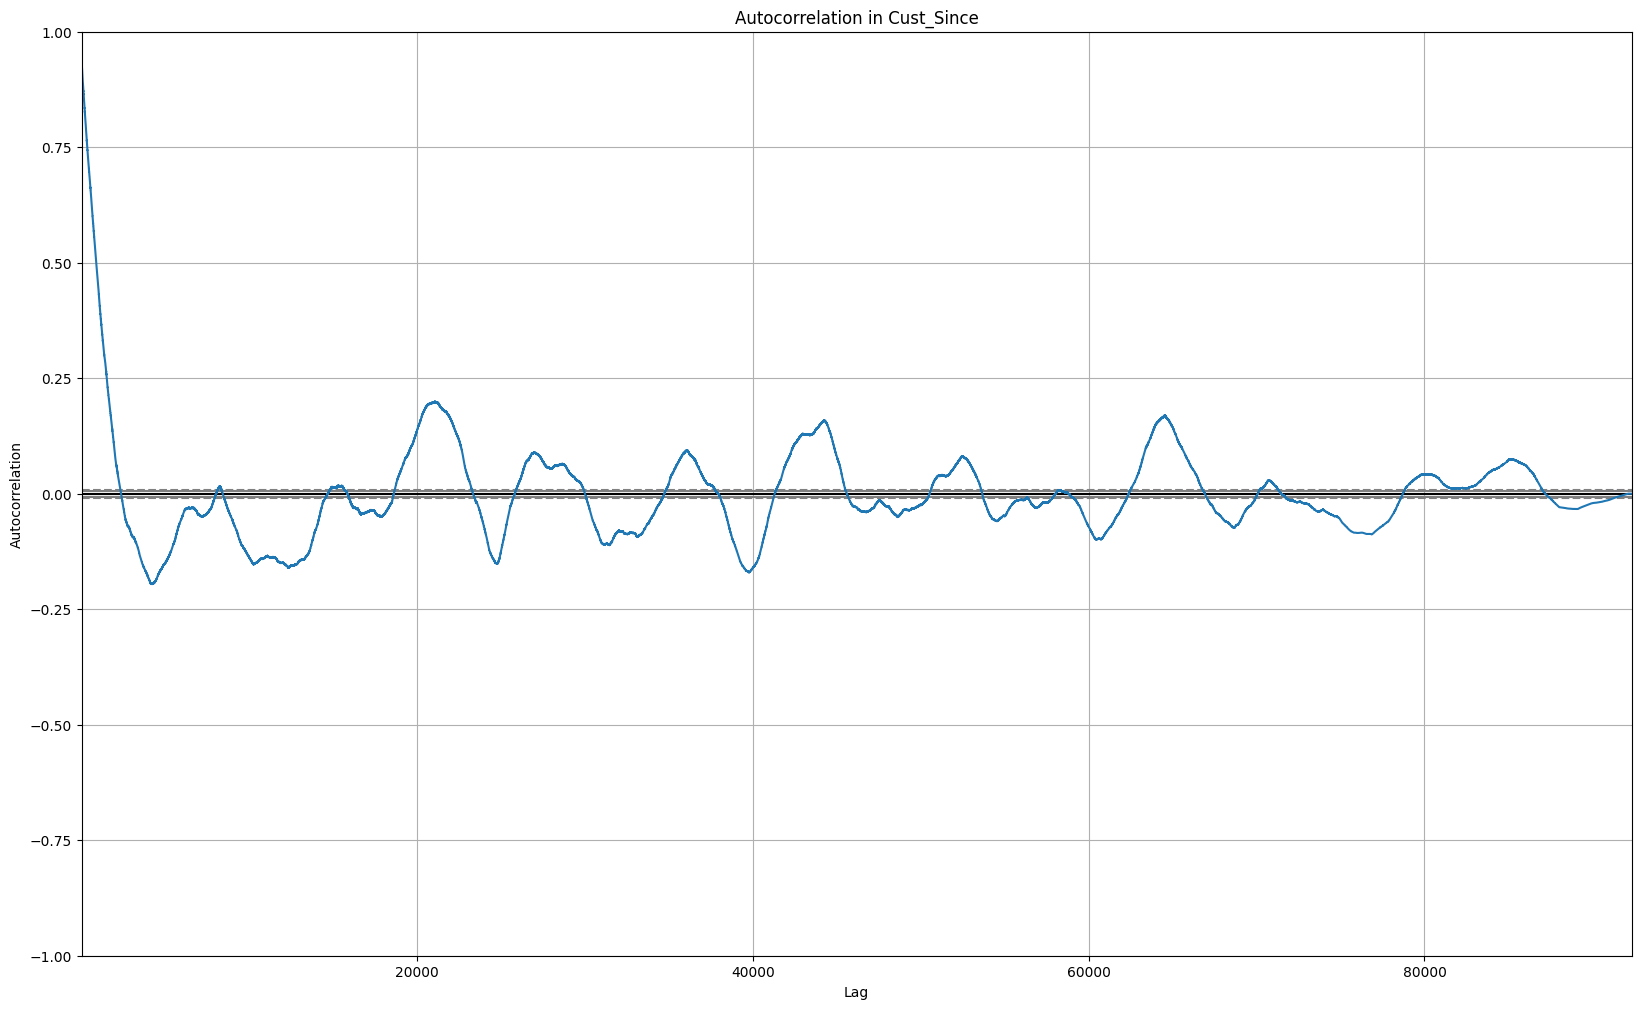

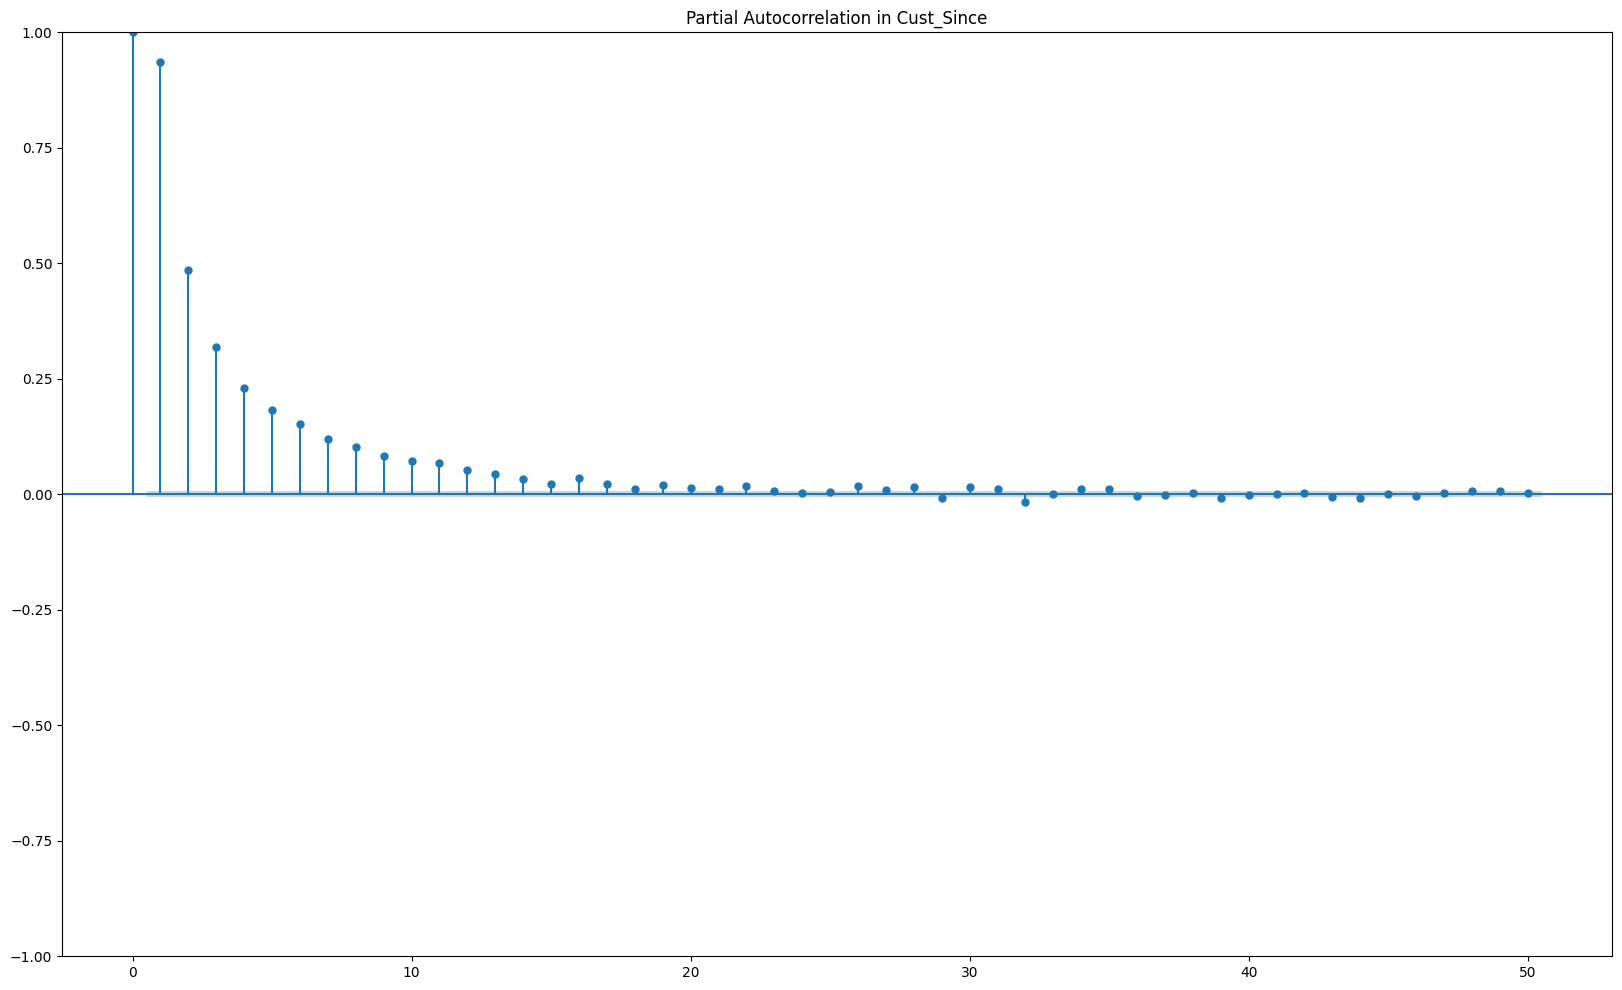

In [ ]:
autocorrelation_plot(df['Cust_Since'].dropna())
plt.title('Autocorrelation in Cust_Since')
plt.show()

plot_pacf(df['Cust_Since'].dropna(), lags=50)
plt.title('Partial Autocorrelation in Cust_Since')
plt.show()

# **Plot 2 - Product Ownership Trend Over**

This plot shows the trends of product ownership across different product types over time, with some products like Savings and Current Accounts having the highest number of clients, remaining relatively stable. Toward the end of the period, there is a notable decline across several products, indicating potential seasonality or external factors impacting customer behavior in the later months.









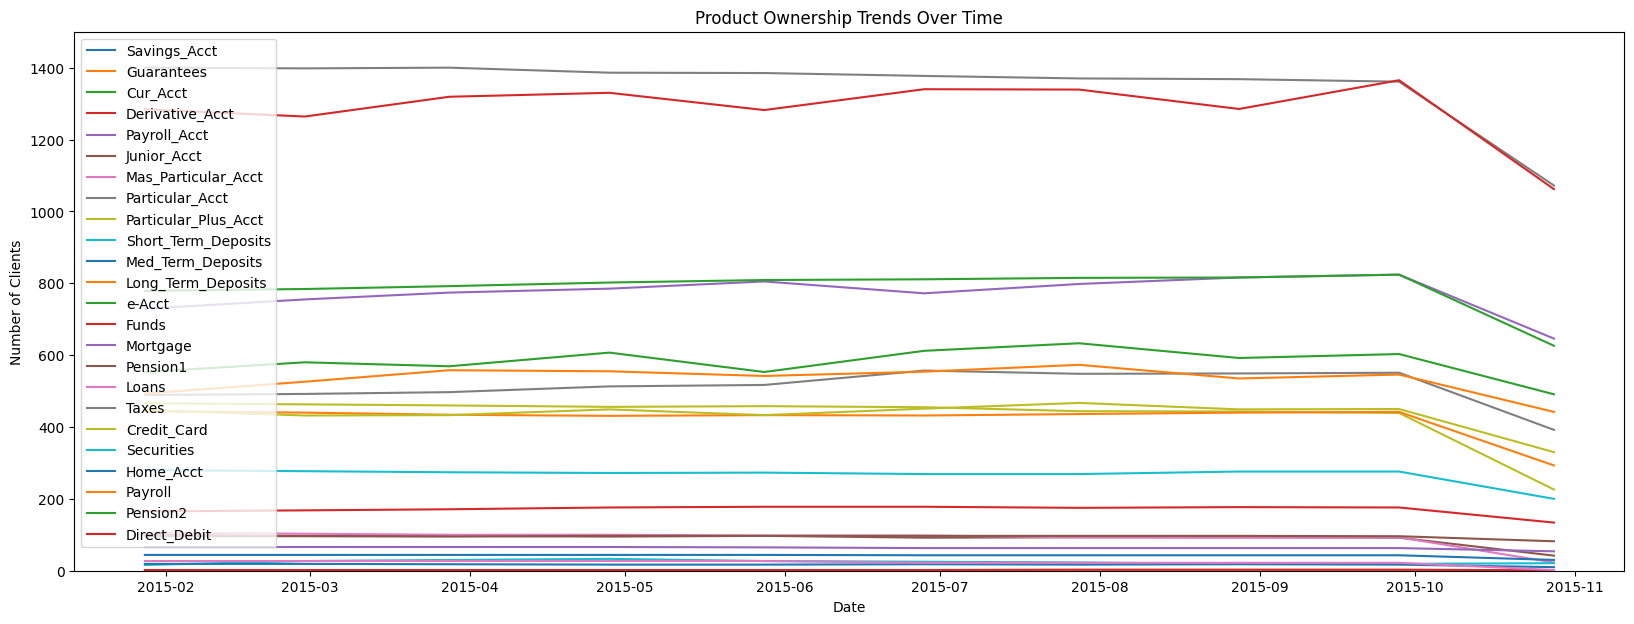

In [ ]:
product_ownership = df.groupby('Status_Dt')[['Savings_Acct', 'Guarantees', 'Cur_Acct', 'Derivative_Acct', 'Payroll_Acct', 'Junior_Acct',
                                             'Mas_Particular_Acct', 'Particular_Acct', 'Particular_Plus_Acct', 'Short_Term_Deposits',
                                             'Med_Term_Deposits', 'Long_Term_Deposits', 'e-Acct', 'Funds', 'Mortgage',
                                             'Pension1', 'Loans', 'Taxes', 'Credit_Card', 'Securities', 'Home_Acct',
                                             'Payroll', 'Pension2', 'Direct_Debit']].sum()


plt.figure(figsize=(20,7))
for column in product_ownership.columns:
    plt.plot(product_ownership.index, product_ownership[column], label=column)

plt.title('Product Ownership Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Clients')
plt.ylim(0, 1500)
plt.legend(loc='upper left')
plt.show()



handling missing values of categorial and numeric values

# **Plot 3 - HeatMap Correlations between Products (Target Variables)**

* Strong positive correlations exist between Payroll_Acct, Loans, and Direct_Debit, suggesting customers who own one are more likely to own the others.
* Products like Credit_Card and Taxes show weaker or negative correlations with other products, indicating they are less likely to be bundled with other services.
* Cust_Since shows moderate correlations with certain product types like  Payroll_Acct and Guarantees, potentially highlighting the role of customer tenure in product ownership.
* High correlation between Savings_Acct and Cur_Acct suggests these products are frequently held together by customers.


# **Insights (I would Proof if i had more time) - What to do with High Correlation?**
Feature reduction: Remove one of the highly correlated features (e.g., Payroll_Acct, Loans, or Direct_Debit) to reduce multicollinearity and simplify the model without losing much information.

Create interaction features: Combine highly correlated features to create interaction terms (e.g., a new feature combining Savings_Acct and Cur_Acct) that may capture more complex relationships and improve model performance.

Segment customers: Use highly correlated products to segment customers into groups, such as those who hold multiple related products, which can enhance personalized marketing or recommendation systems.





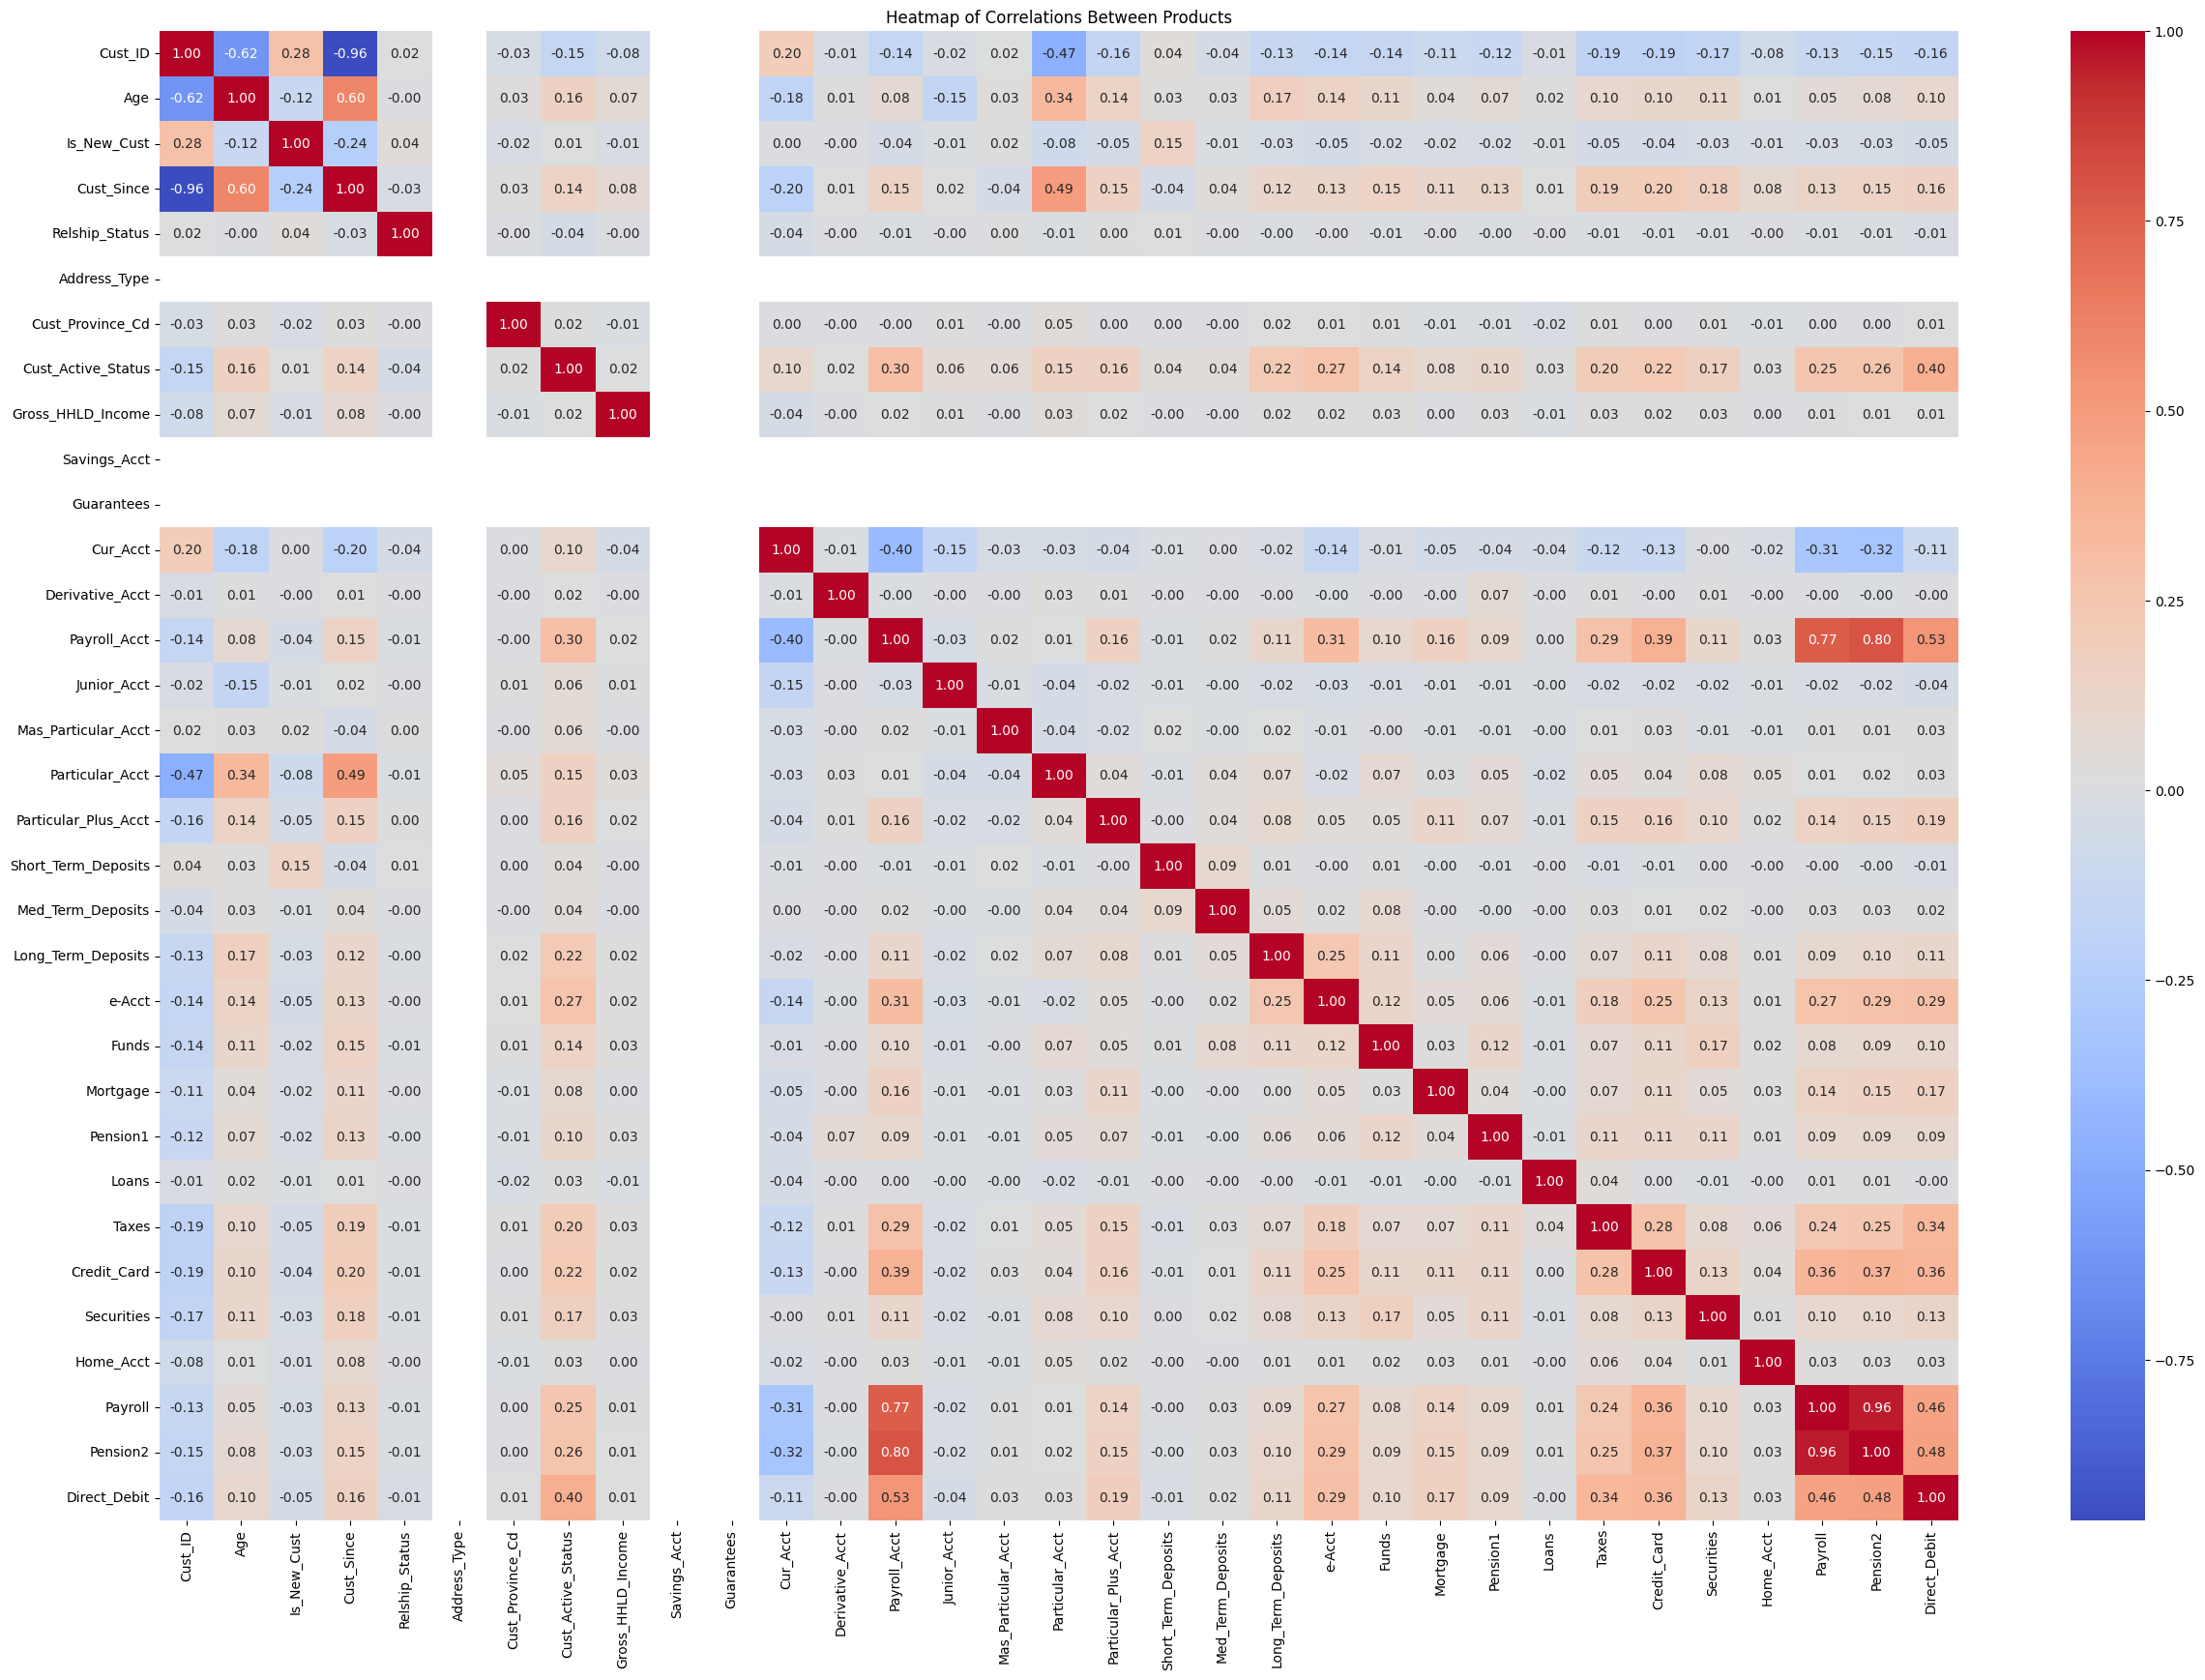

In [ ]:
numeric_df = df.select_dtypes(include=[np.number])

correlation_matrix = numeric_df.corr()

plt.figure(figsize=(30,20))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Heatmap of Correlations Between Products')
plt.show()

# Let's get down, let's get down to business! 🕺💃 👷

After understanding our data better, we would like to train a model to predict the following products a client is about to add or remove.

The development will be segmented into *three* steps.

1.   Create a label vector for each month:
<br>The label vector for each `<client, date>` is the *difference* between the products the client holds in `<date>` and the products of the same client in the consecutive month.<br>
For example, if a client `X` holds a credit card, and does not have a loan or a savings account in March 2019 (translates to the vector `[1,0,0]`) and canceled the credit card in April 2019 but opened a savings account (translates to the vector `[0,0,1]`) - The label for `X, March 2019` will be `[-1,0,1].` <br><br>

2.   Use Feature engineering and Feature selection methods to enrich the training dataset.

3. Use any relevant classification algorithm to predict the shift between consecutive months.
  


## Create labels

In [ ]:
    product_columns = [
        'Savings_Acct', 'Guarantees', 'Cur_Acct', 'Derivative_Acct', 'Payroll_Acct',
        'Junior_Acct', 'Mas_Particular_Acct', 'Particular_Acct', 'Particular_Plus_Acct',
        'Short_Term_Deposits', 'Med_Term_Deposits', 'Long_Term_Deposits', 'e-Acct',
        'Funds', 'Mortgage', 'Pension1', 'Loans', 'Taxes', 'Credit_Card',
        'Securities', 'Home_Acct', 'Payroll', 'Pension2', 'Direct_Debit'
    ]

    df_sorted = df.sort_values(by=['Cust_ID', 'Status_Dt'])
    df_shifted = shift_columns(df_sorted, product_columns)
    df_with_changes = calculate_product_changes(df_shifted, product_columns)
    df_with_changes.fillna(0, inplace=True)

    next_data_label = create_next_data_label(df_with_changes, product_columns)

    return next_data_label


Cust_ID  Status_Dt    Status_Dt_shifted  Savings_Acct_change  \
416972     15899 2015-01-28  2015-02-28 00:00:00                  0.0   
836217     15899 2015-02-28  2015-03-28 00:00:00                  0.0   
1673954    15899 2015-03-28  2015-04-28 00:00:00                  0.0   
2092177    15899 2015-04-28  2015-05-28 00:00:00                  0.0   
2933727    15899 2015-05-28  2015-06-28 00:00:00                  0.0   

         Guarantees_change  Cur_Acct_change  Derivative_Acct_change  \
416972                 0.0              0.0                     0.0   
836217                 0.0              0.0                     0.0   
1673954                0.0              0.0                     0.0   
2092177                0.0              0.0                     0.0   
2933727                0.0              0.0                     0.0   

         Payroll_Acct_change  Junior_Acct_change  Mas_Particular_Acct_change  \
416972                   0.0                 0.0                         0.0   
836217                   0.0                 0.0                         0.0   
1673954                  0.0                 0.0                         0.0   
2092177                  0.0                 0.0                         0.0   
2933727                  0.0                 0.0                         0.0   

         ...  Mortgage_change  Pension1_change  Loans_change  Taxes_change  \
416972   ...              0.0              0.0           0.0           0.0   
836217   ...              0.0              0.0           0.0           0.0   
1673954  ...              0.0              0.0           0.0           0.0   
2092177  ...              0.0              0.0           0.0           0.0   
2933727  ...              0.0              0.0           0.0           0.0   

         Credit_Card_change  Securities_change  Home_Acct_change  \
416972                  0.0                0.0               0.0   
836217                  0.0                0.0               0.0   
1673954                 0.0                0.0               0.0   
2092177                 0.0                0.0               0.0   
2933727                 0.0                0.0               0.0   

         Payroll_change  Pension2_change  Direct_Debit_change  
416972              0.0              0.0                  0.0  
836217              0.0              0.0                  0.0  
1673954             0.0              0.0                  0.0  
2092177             0.0              0.0                  0.0  
2933727             0.0              0.0                  0.0  

[5 rows x 27 columns]

In [ ]:
# Because we only care about behavioural changes, we filter rows with no product change in the consecutive month.
trainable_objects = next_data_label.iloc[:,3:].any(axis=1).to_numpy().nonzero()[0]
next_data_label_relevant = next_data_label.iloc[trainable_objects]

## Create features

#### Feature engineering 👨‍🔧 📏 📝 📊
Feature engineering is a crucial part of working with tabular data.

We love new libraries and papers and try to be up-to-date as much as possible here at Insait.

Use any feature engineering method or library you know and love, and create new features to enrich your data.
You can choose to do automatic feature engineering or knowledge-based by manually thinking on logical correlations.

# **Cleaning**

In the cleaning process, I handled missing values for categorical columns by filling them with appropriate values such as 0, 'Missing', or False depending on the context, and used mode imputation for the remaining columns. For numeric columns, I applied linear interpolation to estimate missing values, ensuring smooth transitions and consistency across the dataset.

In [ ]:
enriched_df = df.iloc[:, :24].copy()
enriched_df = enriched_df.sort_values(by=['Cust_ID', 'Status_Dt'])

enriched_df['Deceased_Flg'] = enriched_df['Deceased_Flg'].fillna(0)
enriched_df['Is_Spouse_Emp'] = enriched_df['Is_Spouse_Emp'].fillna(0)
enriched_df['Join_Channel'] = enriched_df['Join_Channel'].fillna('Missing')
enriched_df['Cust_Segment'] = enriched_df['Cust_Segment'].fillna('Missing')

categorical_columns = ['Emp_Status', 'Cust_Ctry', 'Cust_Sex', 'Cust_Type_Mth_Beg',
                       'Cust_Relship_Type_Mth_Beg', 'Residence_Ctry']
for col in categorical_columns:
    enriched_df[col] = enriched_df[col].fillna(enriched_df[col].mode()[0])

numeric_columns = ['Age', 'Cust_Since', 'Gross_HHLD_Income']
for col in numeric_columns:
    enriched_df[col] = enriched_df[col].interpolate(method='linear')

high_missing_columns = ['Lst_Dt_Primary_Cust', 'Is_Spouse_Emp']
for col in high_missing_columns:
    if enriched_df[col].isnull().mean() > 0.95:
        enriched_df[col] = enriched_df[col].fillna(0)

def standardize_cust_type(value):
    if isinstance(value, str) and value.replace('.', '', 1).isdigit():
        return str(float(value))
    return value

enriched_df['Cust_Type_Mth_Beg'] = enriched_df['Cust_Type_Mth_Beg'].apply(standardize_cust_type)
enriched_df['Cust_Type_Mth_Beg'] = enriched_df['Cust_Type_Mth_Beg'].astype(str)
enriched_df['Cust_Province_Name'] = enriched_df['Cust_Province_Name'].fillna(0)
enriched_df['Cust_Province_Cd'] = enriched_df['Cust_Province_Cd'].fillna(0)
enriched_df['Address_Type'] = enriched_df['Address_Type'].fillna(0)
enriched_df['Relship_Status'] = enriched_df['Relship_Status'].fillna(0)
enriched_df['Is_Foreigner'] = enriched_df['Is_Foreigner'].fillna(False)
enriched_df['Cust_Active_Status'] = enriched_df['Cust_Active_Status'].fillna(0)
enriched_df['Is_New_Cust'] = enriched_df['Is_New_Cust'].fillna(0)

earliest_known_date = enriched_df['Join_Dt'].min()
oldest_new_customer_date = enriched_df[enriched_df['Is_New_Cust'] == 1]['Join_Dt'].min()

enriched_df.loc[enriched_df['Is_New_Cust'] == 0, 'Join_Dt'] = enriched_df['Join_Dt'].fillna(earliest_known_date)
enriched_df.loc[enriched_df['Is_New_Cust'] == 1, 'Join_Dt'] = enriched_df['Join_Dt'].fillna(oldest_new_customer_date)

print("NaN values after final cleaning:\n", enriched_df.isnull().sum()[enriched_df.isnull().sum() > 0])


NaN values after final cleaning:
 Series([], dtype: int64)


# **Encoding And Feature Creation**
Remark: One hot encoding is problemsome when there is a lot of unique values to a feature (you get a sparse vector) i think in this case its e nough but i could use deep learning embedding with fixed dimension ( i use rfe instead later on)

 I also added lagged features such as weekly, quarterly, and yearly intervals to capture time-based dependencies. If I had more time, I would normalize skewed values to evaluate if it improves model performance, and I would add moving averages, interaction features, and seasonal decomposition components to better capture temporal patterns.

In [ ]:
datetime_columns = ['Status_Dt', 'Join_Dt', 'Lst_Dt_Primary_Cust']
numeric_columns = ['Age', 'Is_New_Cust', 'Cust_Since', 'Gross_HHLD_Income', 'Payroll', 'Pension2']
one_hot_columns = ['Cust_Ctry', 'Cust_Sex', 'Residence_Ctry', 'Is_Foreigner', 'Is_Spouse_Emp', 'Deceased_Flg', 'Cust_Province_Name', 'Emp_Status', 'Join_Channel']
label_columns = ['Cust_Segment', 'Cust_Type_Mth_Beg', 'Cust_Relship_Type_Mth_Beg']

enriched_df = convert_to_datetime(enriched_df, datetime_columns)
enriched_df = add_lagged_features(enriched_df, datetime_columns)
enriched_df = process_numeric_features(enriched_df, numeric_columns)
enriched_df = process_categorical_features(enriched_df, one_hot_columns, label_columns)

print(enriched_df.head())


         Status_Dt  Cust_ID   Age    Join_Dt  Is_New_Cust  Cust_Since  \
416972  2015-01-28    15899  57.0 1995-01-16          0.0       246.0   
836217  2015-02-28    15899  57.0 1995-01-16          0.0       246.0   
1673954 2015-03-28    15899  57.0 1995-01-16          0.0       246.0   
2092177 2015-04-28    15899  57.0 1995-01-16          0.0       246.0   
2933727 2015-05-28    15899  57.0 1995-01-16          0.0       246.0   

         Relship_Status Lst_Dt_Primary_Cust  Cust_Type_Mth_Beg  \
416972              1.0          1970-01-01                  0   
836217              1.0          1970-01-01                  0   
1673954             1.0          1970-01-01                  0   
2092177             1.0          1970-01-01                  0   
2933727             1.0          1970-01-01                  0   

         Cust_Relship_Type_Mth_Beg  ...  Join_Channel_KHE  Join_Channel_KHF  \
416972                           0  ...             False             False   
836217

#### Feature Selection
The financial datasets we use at Insait have hundreds of columns.

Training on such massive datasets lead to bad performance and extended training time.

Suggest a feature selection method (Using an open-source library is welcomed), and filter the provided dataset

In [ ]:
# Assuming next_data_label_relevant has been created and contains the change columns
# Merge the moving averages and other features from enriched_df with next_data_label_relevant

Selecting features using RFE with XGBoost for each target label separately...
Running RFE for target: Savings_Acct_change
Selected features for Savings_Acct_change: ['Join_Channel_KHN', 'Join_Channel_KHO', 'Join_Channel_KHQ', 'Join_Channel_Missing', 'Join_Channel_RED']
Running RFE for target: Guarantees_change
Selected features for Guarantees_change: ['Join_Channel_KHN', 'Join_Channel_KHO', 'Join_Channel_KHQ', 'Join_Channel_Missing', 'Join_Channel_RED']
Running RFE for target: Cur_Acct_change
Selected features for Cur_Acct_change: ['Is_New_Cust', 'Cust_Relship_Type_Mth_Beg', 'Cust_Segment', 'Join_Dt_year', 'Cust_Province_Name_MALAGA']
Running RFE for target: Derivative_Acct_change
Selected features for Derivative_Acct_change: ['Join_Channel_KHN', 'Join_Channel_KHO', 'Join_Channel_KHQ', 'Join_Channel_Missing', 'Join_Channel_RED']
Running RFE for target: Payroll_Acct_change
Selected features for Payroll_Acct_change: ['Age', 'Cust_Active_Status', 'Status_Dt_week', 'Join_Dt_week', 'Cust_Se

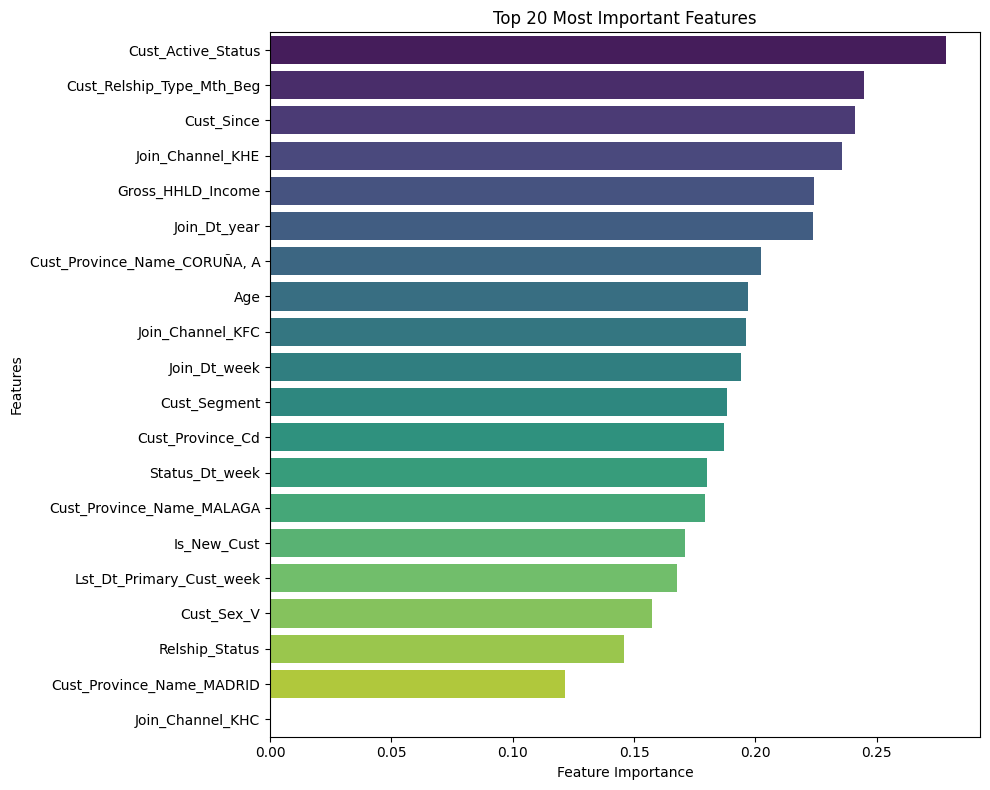

In [ ]:
merged_df = pd.merge(enriched_df, next_data_label, on=['Cust_ID', 'Status_Dt'], how='inner')

subset_size = 5000  # Adjust this size based on your computational limits
if len(merged_df) > subset_size:
    merged_df_sub = merged_df.sample(n=subset_size, random_state=42)
else:
    merged_df_sub = merged_df

columns_to_drop = ['Cust_ID', 'Status_Dt', 'Status_Dt_shifted'] + [f'{col}_change' for col in product_columns]
X = merged_df_sub.drop(columns=columns_to_drop, errors='ignore')
y = merged_df_sub[[f'{col}_change' for col in product_columns]]
y = y.applymap(lambda x: 2 if x == -1 else x)
X = X.select_dtypes(exclude=['datetime', 'timedelta'])
X.fillna(0, inplace=True)

selected_features = []
feature_importances = pd.DataFrame(columns=['Feature', 'Importance', 'Target'])

print("Selecting features using RFE with XGBoost for each target label separately...")

for target_label in y.columns:
    print(f"Running RFE for target: {target_label}")

    unique_values = y[target_label].unique()

    if set(unique_values) == {0, 2}:
        print(f"Remapping 2 to 1 for {target_label} to fit XGBoost binary classification...")
        y[target_label] = y[target_label].replace(2, 1)

    xgb_model = XGBClassifier(
        max_depth=3,
        n_estimators=20,
        n_jobs=-1,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    rfe_selector = BoostRFE(
        estimator=xgb_model,
        min_features_to_select=5,              # Minimum number of features to select
        step=1,                                # Number of features to remove in each step
        param_grid=None,                       # You can add hyperparameter optimization here if needed
        greater_is_better=True,                # Whether higher score is better (e.g., for accuracy)
        importance_type='feature_importances', # Use feature importance
        n_jobs=-1,                             # Parallel jobs
        verbose=1
    )

    rfe_selector.fit(X, y[target_label])

    selected_features_for_label = X.columns[rfe_selector.support_].tolist()
    print(f"Selected features for {target_label}: {selected_features_for_label}")

    selected_features.extend(selected_features_for_label)

    importance = rfe_selector.estimator_.feature_importances_
    selected_features_importance = X.columns[rfe_selector.support_]
    feature_importances_for_label = pd.DataFrame({
        'Feature': selected_features_importance,
        'Importance': importance,
        'Target': target_label
    })
    feature_importances = pd.concat([feature_importances, feature_importances_for_label])

selected_features = list(set(selected_features))
enriched_selected_df = merged_df[selected_features]
top_features = feature_importances.groupby('Feature')['Importance'].mean().reset_index().sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features.head(20), palette='viridis')
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


# **Feature Selection Analysis**
* The chart provides insights into the top 20 most important features based on feature importance from SHAP values.
* I can focus on selecting the top features such as Cust_Active_Status, Join_Channel, and Cust_Province_Name to reduce the feature space and simplify the model.
* Another approach is to create new interaction features based on these important variables, capturing potential relationships or dependencies between them.
* By analyzing the top features, I can also prioritize which categorical variables to apply more advanced encoding techniques on or investigate further for additional patterns.
* These strategies can improve model performance by reducing noise, enhancing interpretability, and potentially capturing latent relationships in the data.

## Modeling

In [ ]:
# 2. Merge the enriched_selected_df with the labels (the products difference vector <next_data_label_relevant>)
# Call the final df `features_labels`

###### Your Code Here ######

enriched_selected_df = merged_df[['Cust_ID', 'Status_Dt', 'Status_Dt_shifted'] + selected_features]
features_labels = pd.merge(enriched_selected_df, next_data_label_relevant, on=['Cust_ID', 'Status_Dt'], how='inner')
print(f"Merged features and labels DataFrame shape: {features_labels.shape}")
print(features_labels.head())


Merged features and labels DataFrame shape: (5539, 53)
   Cust_ID  Status_Dt  Status_Dt_shifted_x  Cust_Province_Name_CORUÑA, A  \
0    16613 2015-01-28  2015-02-28 00:00:00                         False   
1    16613 2015-04-28  2015-05-28 00:00:00                         False   
2    16613 2015-05-28  2015-06-28 00:00:00                         False   
3    16613 2015-07-28  2015-08-28 00:00:00                         False   
4    16613 2015-08-28  2015-09-28 00:00:00                         False   

   Join_Channel_RED  Status_Dt_week  Join_Channel_KHC  Gross_HHLD_Income  \
0             False               5             False           125132.7   
1             False              18             False           125132.7   
2             False              22             False           125132.7   
3             False              31             False           125132.7   
4             False              35             False           125132.7   

   Join_Channel_KHE  Join_Chann

In [ ]:
# Beware! a random train,test split will not work here, as we will leak data to future occurances.
# We will take samples where the next month in the last month in the db as our testing data, and the rest as train.

next_date_last = (features_labels.Status_Dt_shifted_x == features_labels.Status_Dt_shifted_x.max())
train, test = features_labels[next_date_last], features_labels[~next_date_last]

## Training
### It's the final countdown 🍒👷

In [ ]:
train_features, train_labels = prepare_for_model(train)
test_features, test_labels = prepare_for_model(test)

Optuna for Hyperparameter Tuning:
Optuna is an advanced hyperparameter optimization framework designed for automatic and efficient exploration of hyperparameter space. In this project, Optuna was used to tune LightGBM's hyperparameters, allowing for fine adjustments to the model’s learning rate, number of leaves, and other critical parameters. This method offers a competitive advantage because:

It uses Bayesian optimization techniques, focusing on promising regions of the hyperparameter space, which significantly reduces the time and computational cost.
Optuna dynamically prunes unpromising trials early, ensuring faster convergence on optimal parameters, which is crucial for time-sensitive projects.
The classification results show that in many cases, such as "Savings_Acct_change" and "Loans_change," LightGBM achieves high precision and recall, largely due to the effective tuning of parameters by Optuna. However, in more difficult cases (e.g., "Credit_Card_change" and "Direct_Debit_change"), the model struggled, possibly due to the sparsity of data in these target columns.


I evaluated LightGBM's performance across all target columns using three main metrics:

Precision: How often the model's positive predictions were correct.
Recall: How many actual positive instances the model correctly identified.
F1 Score: A balance between precision and recall.
Average Results:
Precision: 0.827
Recall: 0.848
F1 Score: 0.837
Breakdown of the Results:
High Scores: Some columns, like "Savings_Acct_change," "Loans_change," and "Mortgage_change," achieved perfect scores (100% precision, recall, and F1). This means the model was very accurate and reliable for predicting changes in these columns, likely because the data had clear patterns and balance.

Lower Scores: For columns like "Cur_Acct_change," "Credit_Card_change," and "Direct_Debit_change," the model struggled more, with precision and recall averaging around 0.65. These columns probably had noisier or more sparse data, making it harder for the model to predict correctly.

Sparse Data Problems: In columns like "Pension2_change" and "Payroll_change," LightGBM had issues predicting smaller changes (e.g., fewer account changes), resulting in low recall. The model missed many of the actual changes, which highlights its difficulty in dealing with sparse or imbalanced data.

**In Conclusion, LightGBM performed well overall but had trouble predicting changes in cases where the data was more scattered or less frequent.**

Optimizing for target: Savings_Acct_change
Optimizing for target: Guarantees_change
Optimizing for target: Cur_Acct_change
Optimizing for target: Derivative_Acct_change
Optimizing for target: Payroll_Acct_change
Optimizing for target: Junior_Acct_change
Optimizing for target: Mas_Particular_Acct_change
Optimizing for target: Particular_Acct_change
Optimizing for target: Particular_Plus_Acct_change
Optimizing for target: Short_Term_Deposits_change
Optimizing for target: Med_Term_Deposits_change
Optimizing for target: Long_Term_Deposits_change
Optimizing for target: e-Acct_change
Optimizing for target: Funds_change
Optimizing for target: Mortgage_change
Optimizing for target: Pension1_change
Optimizing for target: Loans_change
Optimizing for target: Taxes_change
Optimizing for target: Credit_Card_change
Optimizing for target: Securities_change
Optimizing for target: Home_Acct_change
Optimizing for target: Payroll_change
Optimizing for target: Pension2_change
Optimizing for target: Direct

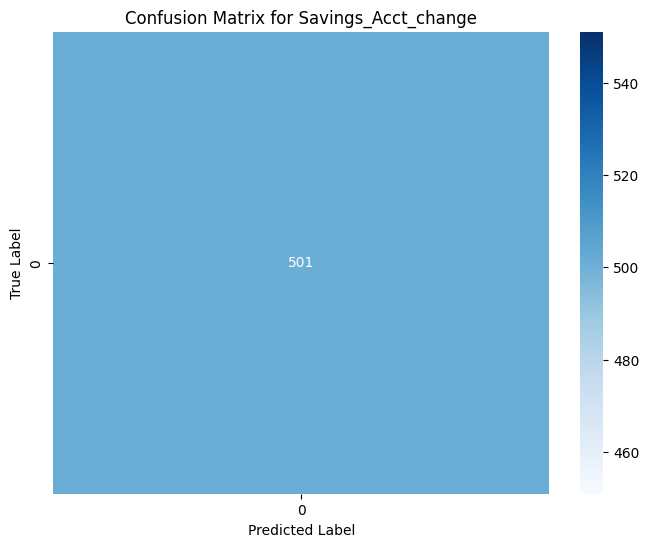

Confusion Matrix for Guarantees_change:
[[501]]
Classification Report for Guarantees_change:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       501

    accuracy                           1.00       501
   macro avg       1.00      1.00      1.00       501
weighted avg       1.00      1.00      1.00       501

Precision: 1.0
Recall: 1.0
F1 Score: 1.0


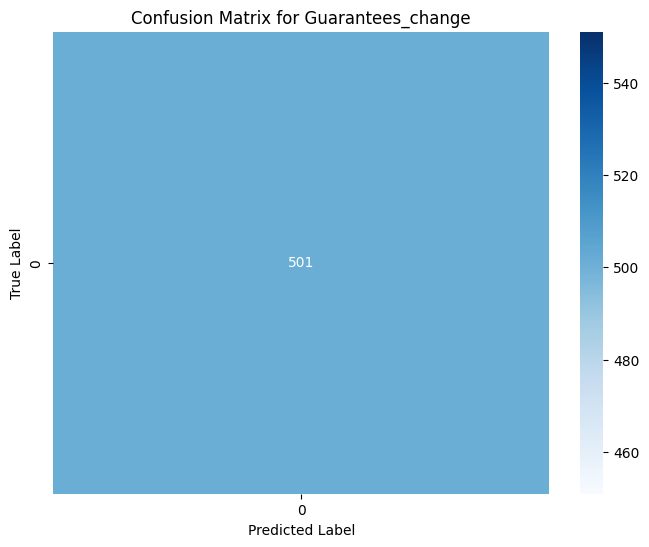

Confusion Matrix for Cur_Acct_change:
[[  0  45   0]
 [  0 420   0]
 [  0  34   2]]
Classification Report for Cur_Acct_change:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        45
         0.0       0.84      1.00      0.91       420
         1.0       1.00      0.06      0.11        36

    accuracy                           0.84       501
   macro avg       0.61      0.35      0.34       501
weighted avg       0.78      0.84      0.77       501

Precision: 0.7774591098364394
Recall: 0.8423153692614771
F1 Score: 0.7738223798665769


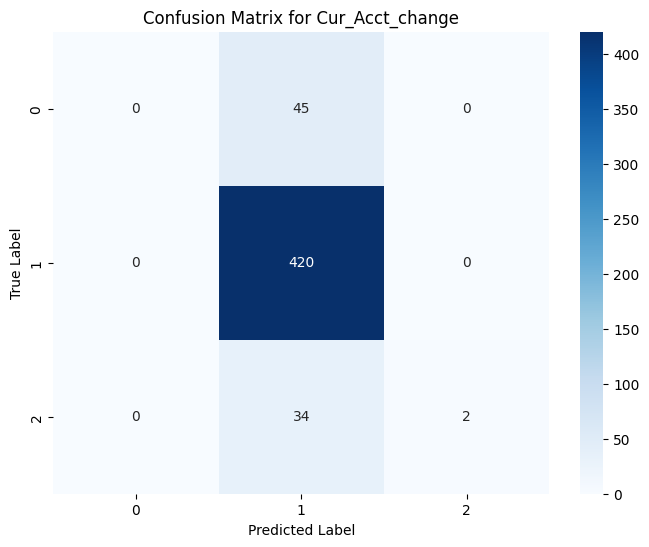

Confusion Matrix for Derivative_Acct_change:
[[501]]
Classification Report for Derivative_Acct_change:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       501

    accuracy                           1.00       501
   macro avg       1.00      1.00      1.00       501
weighted avg       1.00      1.00      1.00       501

Precision: 1.0
Recall: 1.0
F1 Score: 1.0


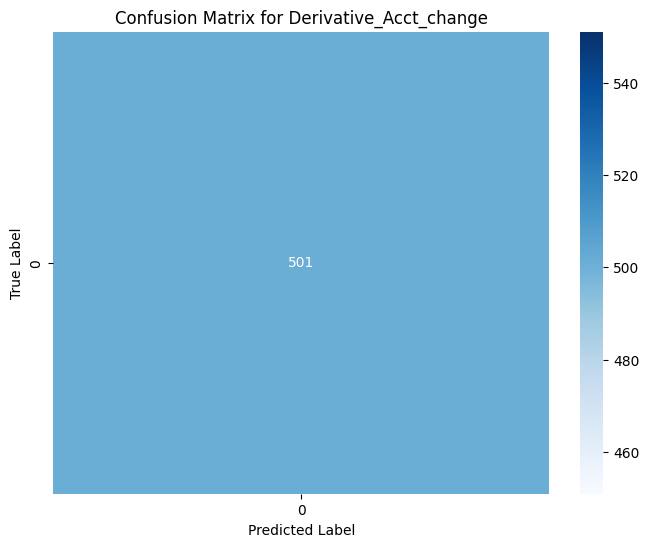

Confusion Matrix for Payroll_Acct_change:
[[  0  11   1]
 [  0 464   1]
 [  0  22   2]]
Classification Report for Payroll_Acct_change:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        12
         0.0       0.93      1.00      0.96       465
         1.0       0.50      0.08      0.14        24

    accuracy                           0.93       501
   macro avg       0.48      0.36      0.37       501
weighted avg       0.89      0.93      0.90       501

Precision: 0.8904685598621671
Recall: 0.9301397205588823
F1 Score: 0.9021837524831536


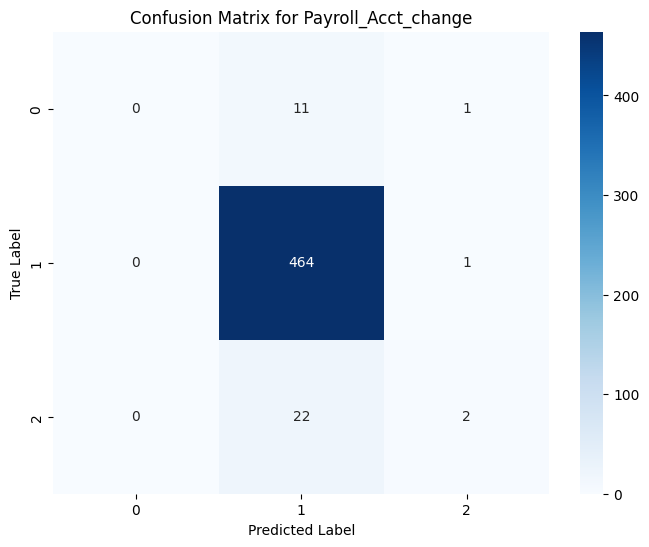

Confusion Matrix for Junior_Acct_change:
[[  0   5]
 [  0 496]]
Classification Report for Junior_Acct_change:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         5
         0.0       0.99      1.00      0.99       496

    accuracy                           0.99       501
   macro avg       0.50      0.50      0.50       501
weighted avg       0.98      0.99      0.99       501

Precision: 0.9801395213564885
Recall: 0.9900199600798403
F1 Score: 0.9850549652950867


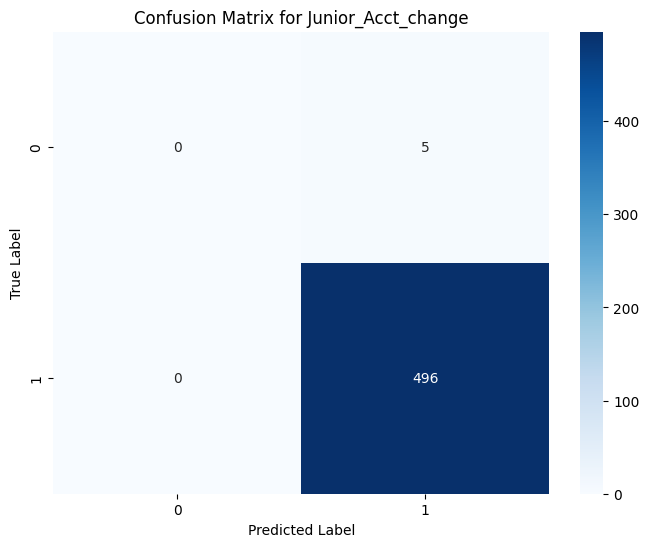

Confusion Matrix for Mas_Particular_Acct_change:
[[  0   4   0]
 [  0 495   0]
 [  0   2   0]]
Classification Report for Mas_Particular_Acct_change:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         4
         0.0       0.99      1.00      0.99       495
         1.0       0.00      0.00      0.00         2

    accuracy                           0.99       501
   macro avg       0.33      0.33      0.33       501
weighted avg       0.98      0.99      0.98       501

Precision: 0.9761913299150202
Recall: 0.9880239520958084
F1 Score: 0.9820720005771588


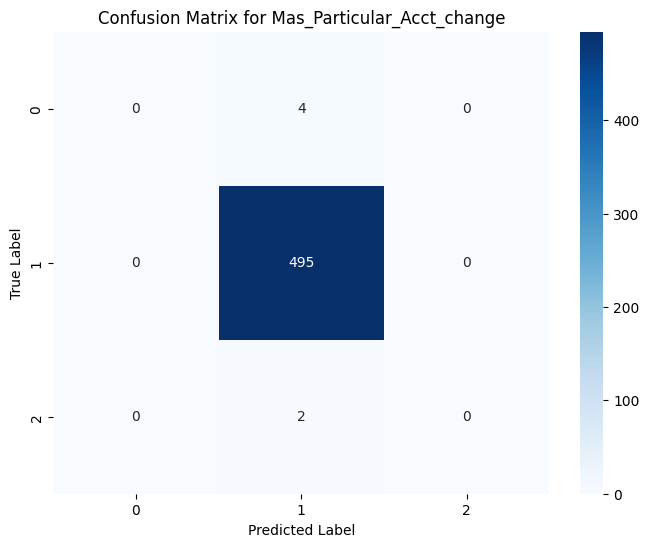

Confusion Matrix for Particular_Acct_change:
[[  0   8   0]
 [  0 491   0]
 [  0   2   0]]
Classification Report for Particular_Acct_change:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         8
         0.0       0.98      1.00      0.99       491
         1.0       0.00      0.00      0.00         2

    accuracy                           0.98       501
   macro avg       0.33      0.33      0.33       501
weighted avg       0.96      0.98      0.97       501

Precision: 0.9604782451065932
Recall: 0.9800399201596807
F1 Score: 0.9701604854806516


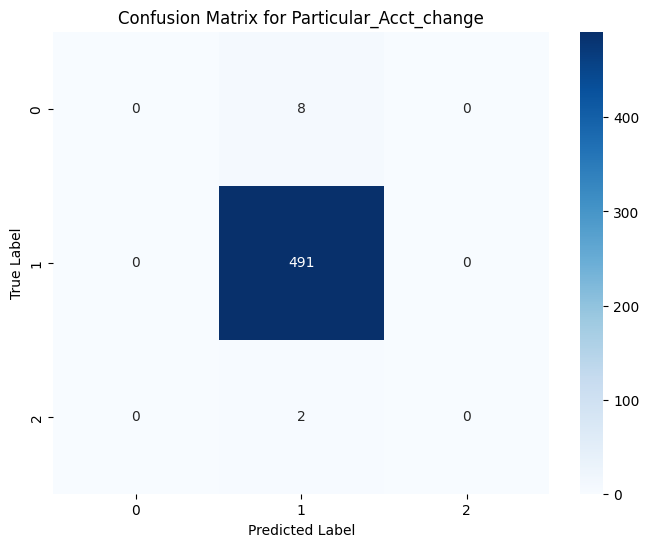

Confusion Matrix for Particular_Plus_Acct_change:
[[  0   5   0]
 [  0 495   0]
 [  0   1   0]]
Classification Report for Particular_Plus_Acct_change:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         5
         0.0       0.99      1.00      0.99       495
         1.0       0.00      0.00      0.00         1

    accuracy                           0.99       501
   macro avg       0.33      0.33      0.33       501
weighted avg       0.98      0.99      0.98       501

Precision: 0.9761913299150202
Recall: 0.9880239520958084
F1 Score: 0.9820720005771588


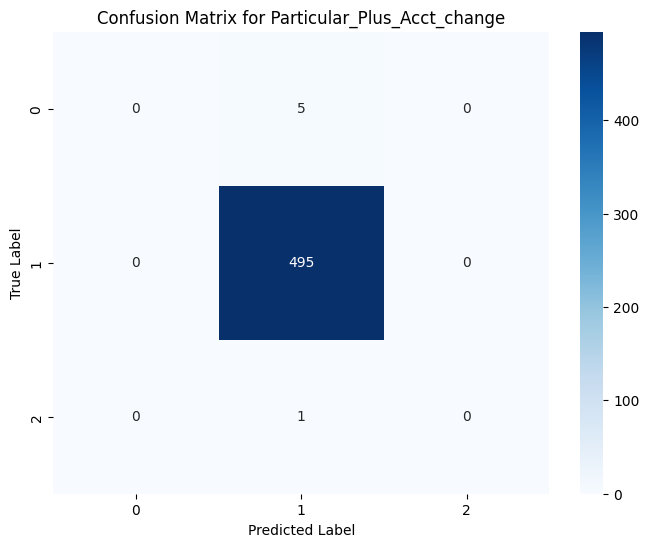

Confusion Matrix for Short_Term_Deposits_change:
[[  0   4   0]
 [  0 496   0]
 [  0   1   0]]
Classification Report for Short_Term_Deposits_change:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         4
         0.0       0.99      1.00      0.99       496
         1.0       0.00      0.00      0.00         1

    accuracy                           0.99       501
   macro avg       0.33      0.33      0.33       501
weighted avg       0.98      0.99      0.99       501

Precision: 0.9801395213564885
Recall: 0.9900199600798403
F1 Score: 0.9850549652950867


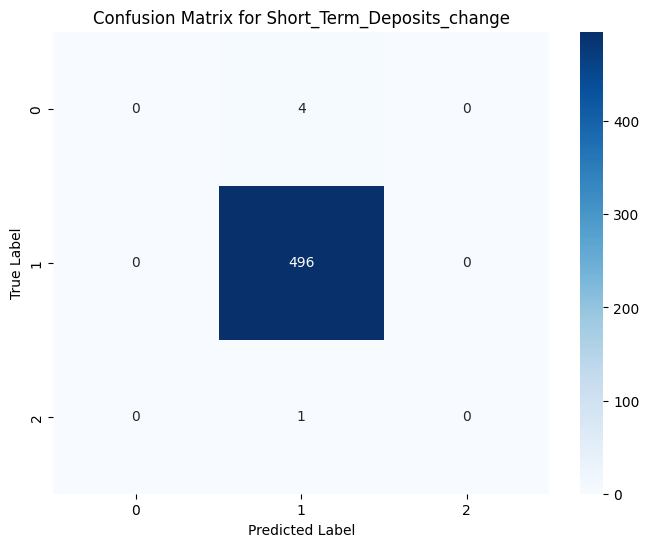

Confusion Matrix for Med_Term_Deposits_change:
[[  0   1   0]
 [  0 499   0]
 [  0   1   0]]
Classification Report for Med_Term_Deposits_change:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         1
         0.0       1.00      1.00      1.00       499
         1.0       0.00      0.00      0.00         1

    accuracy                           1.00       501
   macro avg       0.33      0.33      0.33       501
weighted avg       0.99      1.00      0.99       501

Precision: 0.9920319042553616
Recall: 0.9960079840319361
F1 Score: 0.9940159680638724


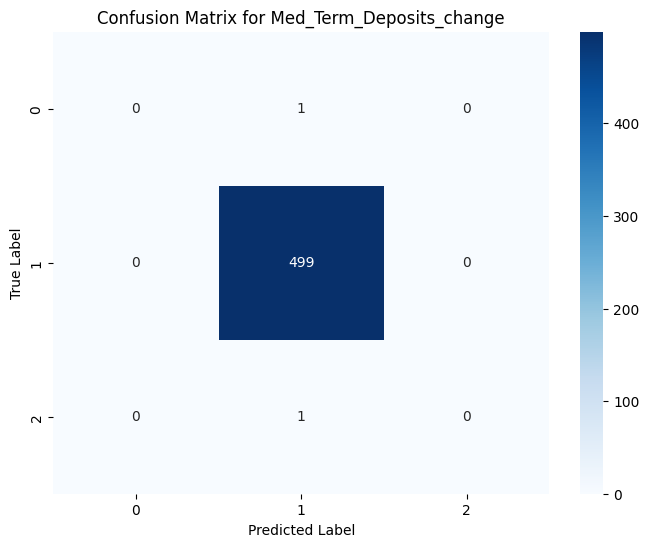

Confusion Matrix for Long_Term_Deposits_change:
[[  0  17   0]
 [  0 471   0]
 [  0  13   0]]
Classification Report for Long_Term_Deposits_change:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        17
         0.0       0.94      1.00      0.97       471
         1.0       0.00      0.00      0.00        13

    accuracy                           0.94       501
   macro avg       0.31      0.33      0.32       501
weighted avg       0.88      0.94      0.91       501

Precision: 0.8838251640431711
Recall: 0.9401197604790419
F1 Score: 0.911103718488948


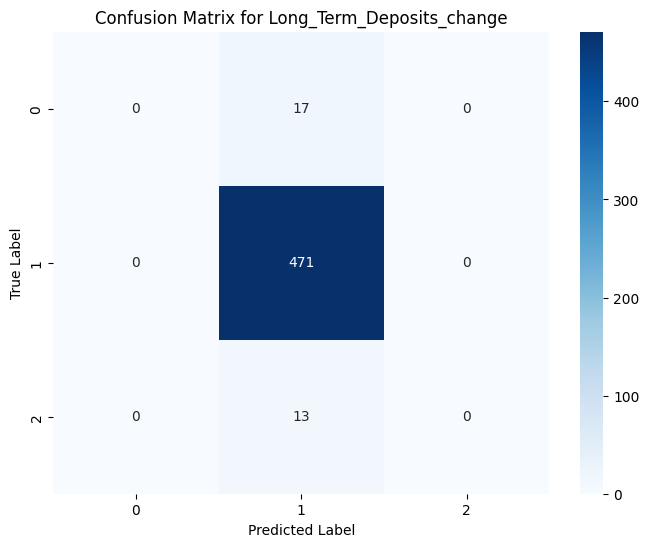

Confusion Matrix for e-Acct_change:
[[  0  11   0]
 [  0 475   0]
 [  0  14   1]]
Classification Report for e-Acct_change:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        11
         0.0       0.95      1.00      0.97       475
         1.0       1.00      0.07      0.12        15

    accuracy                           0.95       501
   macro avg       0.65      0.36      0.37       501
weighted avg       0.93      0.95      0.93       501

Precision: 0.9306387225548902
Recall: 0.9500998003992016
F1 Score: 0.9275359537335586


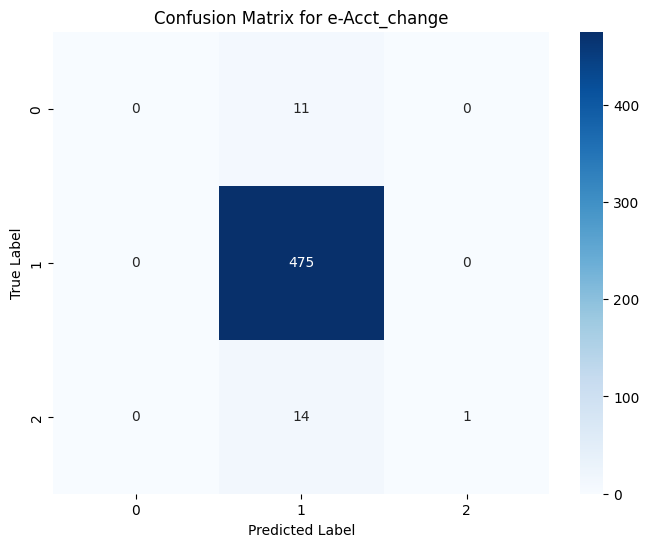

Confusion Matrix for Funds_change:
[[  0   1   0]
 [  0 498   0]
 [  0   2   0]]
Classification Report for Funds_change:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         1
         0.0       0.99      1.00      1.00       498
         1.0       0.00      0.00      0.00         2

    accuracy                           0.99       501
   macro avg       0.33      0.33      0.33       501
weighted avg       0.99      0.99      0.99       501

Precision: 0.9880598085266592
Recall: 0.9940119760479041
F1 Score: 0.9910269550988113


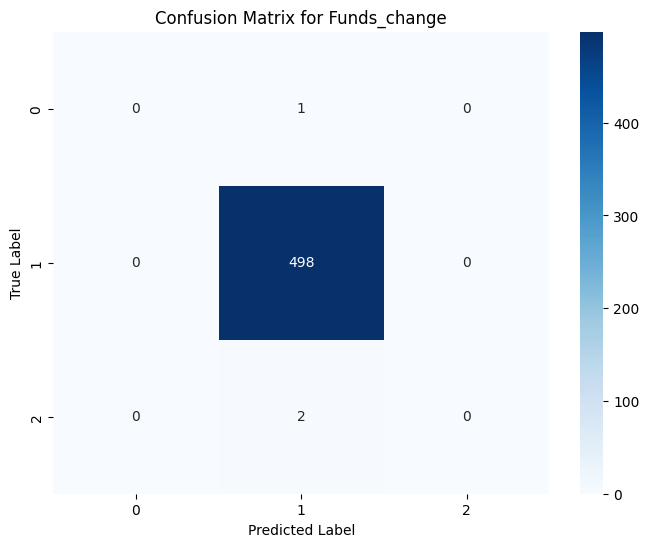

Confusion Matrix for Mortgage_change:
[[501]]
Classification Report for Mortgage_change:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       501

    accuracy                           1.00       501
   macro avg       1.00      1.00      1.00       501
weighted avg       1.00      1.00      1.00       501

Precision: 1.0
Recall: 1.0
F1 Score: 1.0


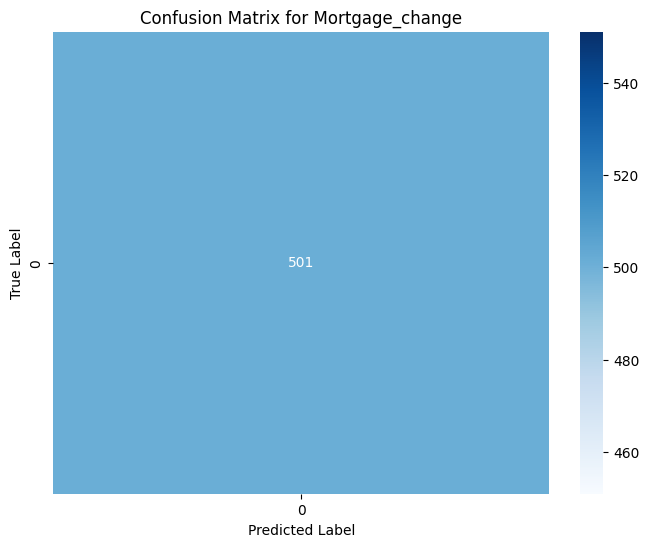

Confusion Matrix for Pension1_change:
[[  0   1   0]
 [  0 499   0]
 [  0   1   0]]
Classification Report for Pension1_change:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         1
         0.0       1.00      1.00      1.00       499
         1.0       0.00      0.00      0.00         1

    accuracy                           1.00       501
   macro avg       0.33      0.33      0.33       501
weighted avg       0.99      1.00      0.99       501

Precision: 0.9920319042553616
Recall: 0.9960079840319361
F1 Score: 0.9940159680638724


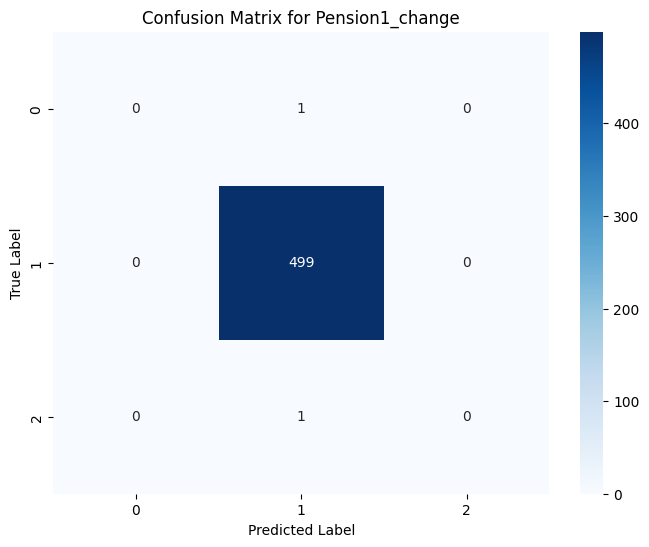

Confusion Matrix for Loans_change:
[[501]]
Classification Report for Loans_change:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       501

    accuracy                           1.00       501
   macro avg       1.00      1.00      1.00       501
weighted avg       1.00      1.00      1.00       501

Precision: 1.0
Recall: 1.0
F1 Score: 1.0


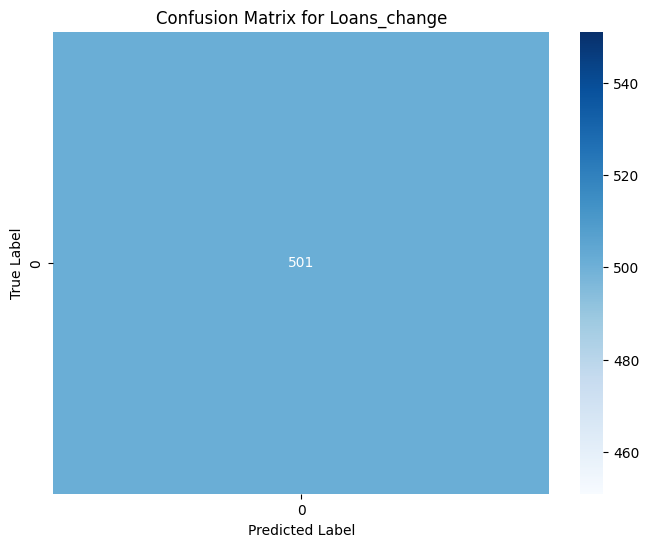

Confusion Matrix for Taxes_change:
[[495   0]
 [  6   0]]
Classification Report for Taxes_change:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       495
         1.0       0.00      0.00      0.00         6

    accuracy                           0.99       501
   macro avg       0.49      0.50      0.50       501
weighted avg       0.98      0.99      0.98       501

Precision: 0.9761913299150202
Recall: 0.9880239520958084
F1 Score: 0.9820720005771588


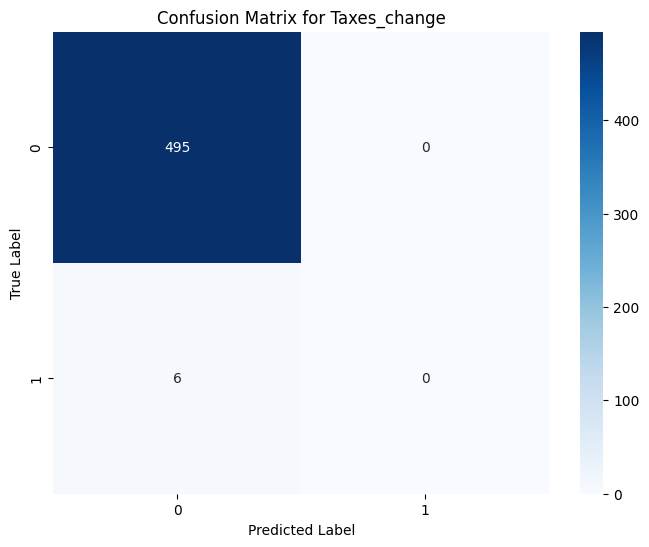

Confusion Matrix for Credit_Card_change:
[[  0  59   0]
 [  0 404   0]
 [  0  38   0]]
Classification Report for Credit_Card_change:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        59
         0.0       0.81      1.00      0.89       404
         1.0       0.00      0.00      0.00        38

    accuracy                           0.81       501
   macro avg       0.27      0.33      0.30       501
weighted avg       0.65      0.81      0.72       501

Precision: 0.6502603575284561
Recall: 0.8063872255489022
F1 Score: 0.7199567715397934


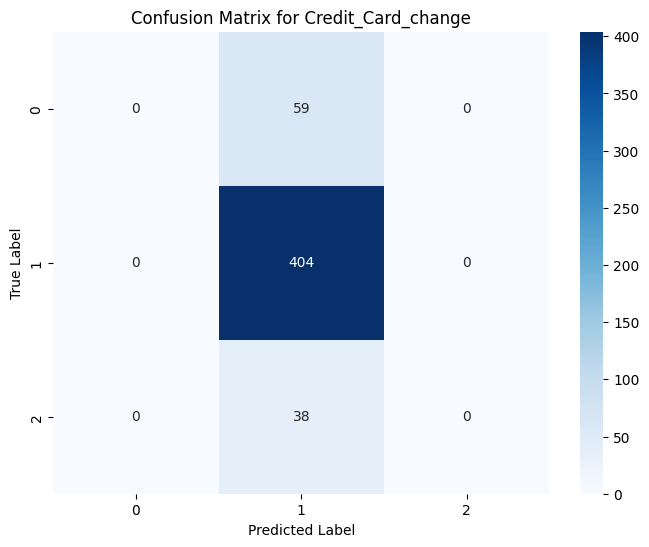

Confusion Matrix for Securities_change:
[[  0   3   0]
 [  0 494   0]
 [  0   4   0]]
Classification Report for Securities_change:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         3
         0.0       0.99      1.00      0.99       494
         1.0       0.00      0.00      0.00         4

    accuracy                           0.99       501
   macro avg       0.33      0.33      0.33       501
weighted avg       0.97      0.99      0.98       501

Precision: 0.9722511065692965
Recall: 0.9860279441117764
F1 Score: 0.97909106410295


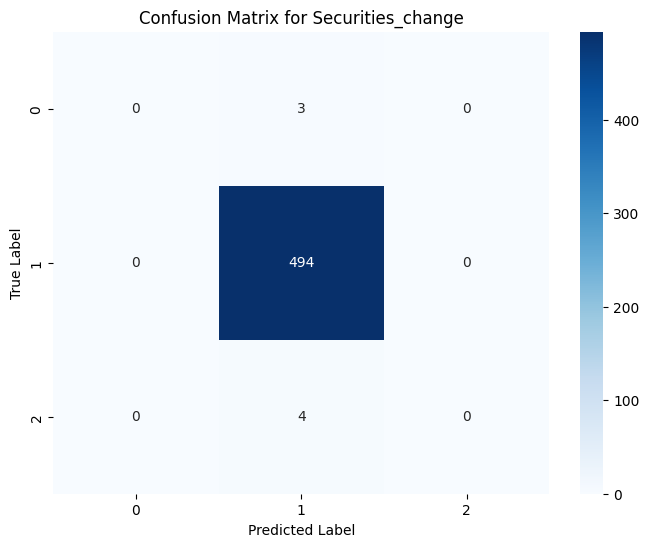

Confusion Matrix for Home_Acct_change:
[[501]]
Classification Report for Home_Acct_change:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       501

    accuracy                           1.00       501
   macro avg       1.00      1.00      1.00       501
weighted avg       1.00      1.00      1.00       501

Precision: 1.0
Recall: 1.0
F1 Score: 1.0


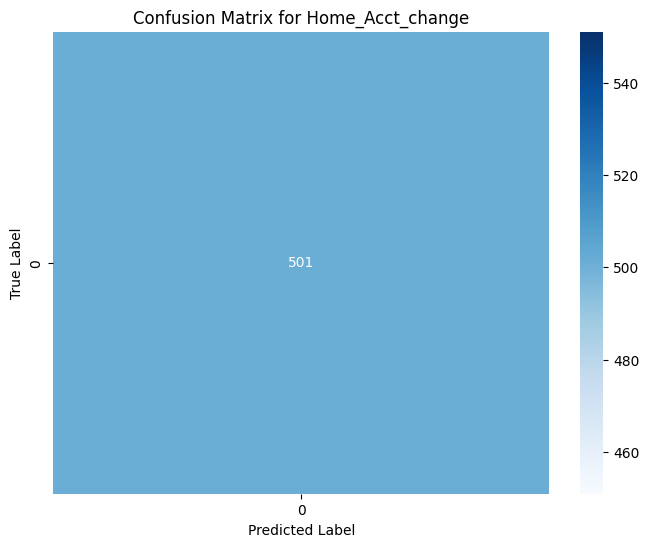

Confusion Matrix for Payroll_change:
[[  0  41   0]
 [  0 416   0]
 [  0  44   0]]
Classification Report for Payroll_change:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        41
         0.0       0.83      1.00      0.91       416
         1.0       0.00      0.00      0.00        44

    accuracy                           0.83       501
   macro avg       0.28      0.33      0.30       501
weighted avg       0.69      0.83      0.75       501

Precision: 0.6894633885920772
Recall: 0.8303393213572854
F1 Score: 0.7533722086905795


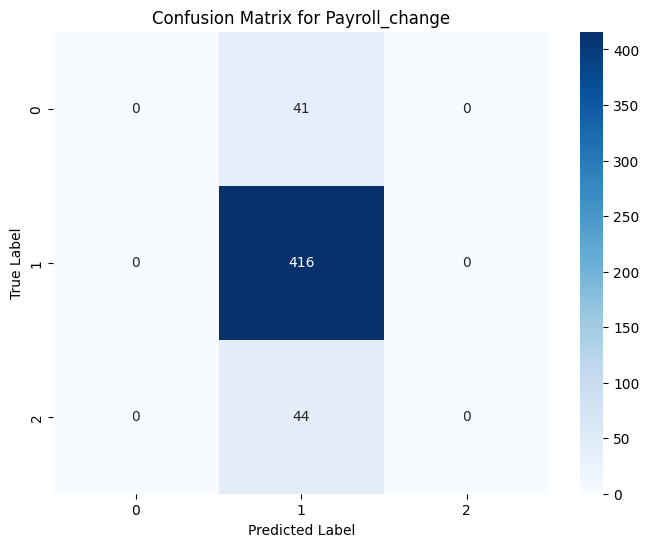

Confusion Matrix for Pension2_change:
[[  0  48   0]
 [  0 397   0]
 [  0  56   0]]
Classification Report for Pension2_change:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        48
         0.0       0.79      1.00      0.88       397
         1.0       0.00      0.00      0.00        56

    accuracy                           0.79       501
   macro avg       0.26      0.33      0.29       501
weighted avg       0.63      0.79      0.70       501

Precision: 0.627921801108362
Recall: 0.7924151696606786
F1 Score: 0.700643256916012


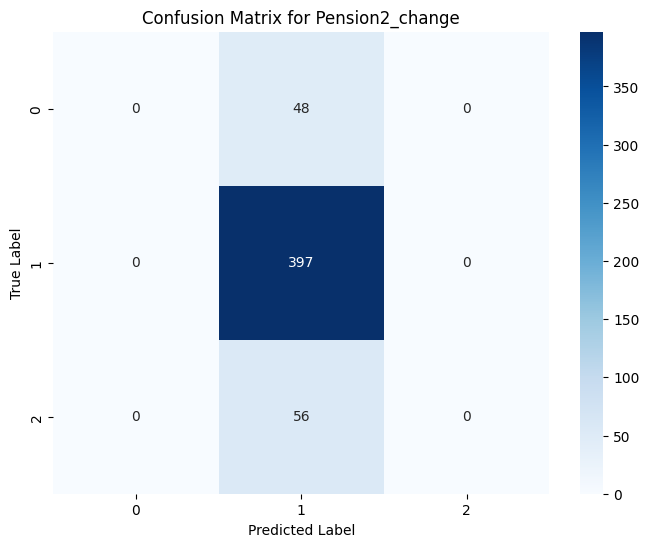

Confusion Matrix for Direct_Debit_change:
[[  0  74   7]
 [  0 317  10]
 [  0  84   9]]
Classification Report for Direct_Debit_change:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        81
         0.0       0.67      0.97      0.79       327
         1.0       0.35      0.10      0.15        93

    accuracy                           0.65       501
   macro avg       0.34      0.36      0.31       501
weighted avg       0.50      0.65      0.54       501

Precision: 0.49984387500303046
Recall: 0.6506986027944112
F1 Score: 0.544048849847404


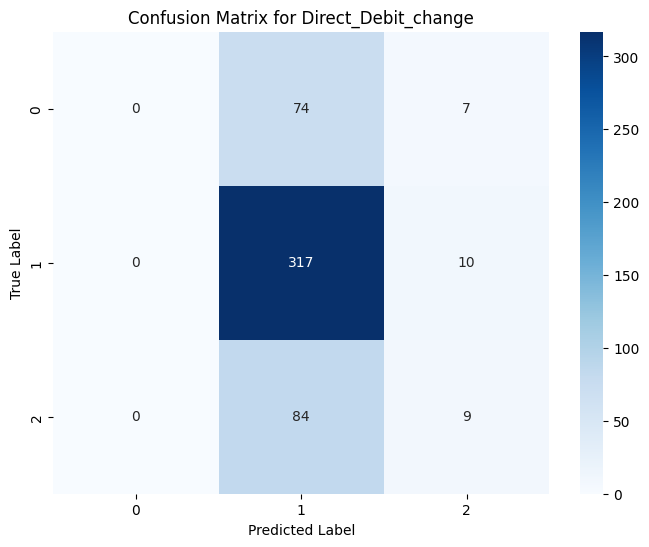

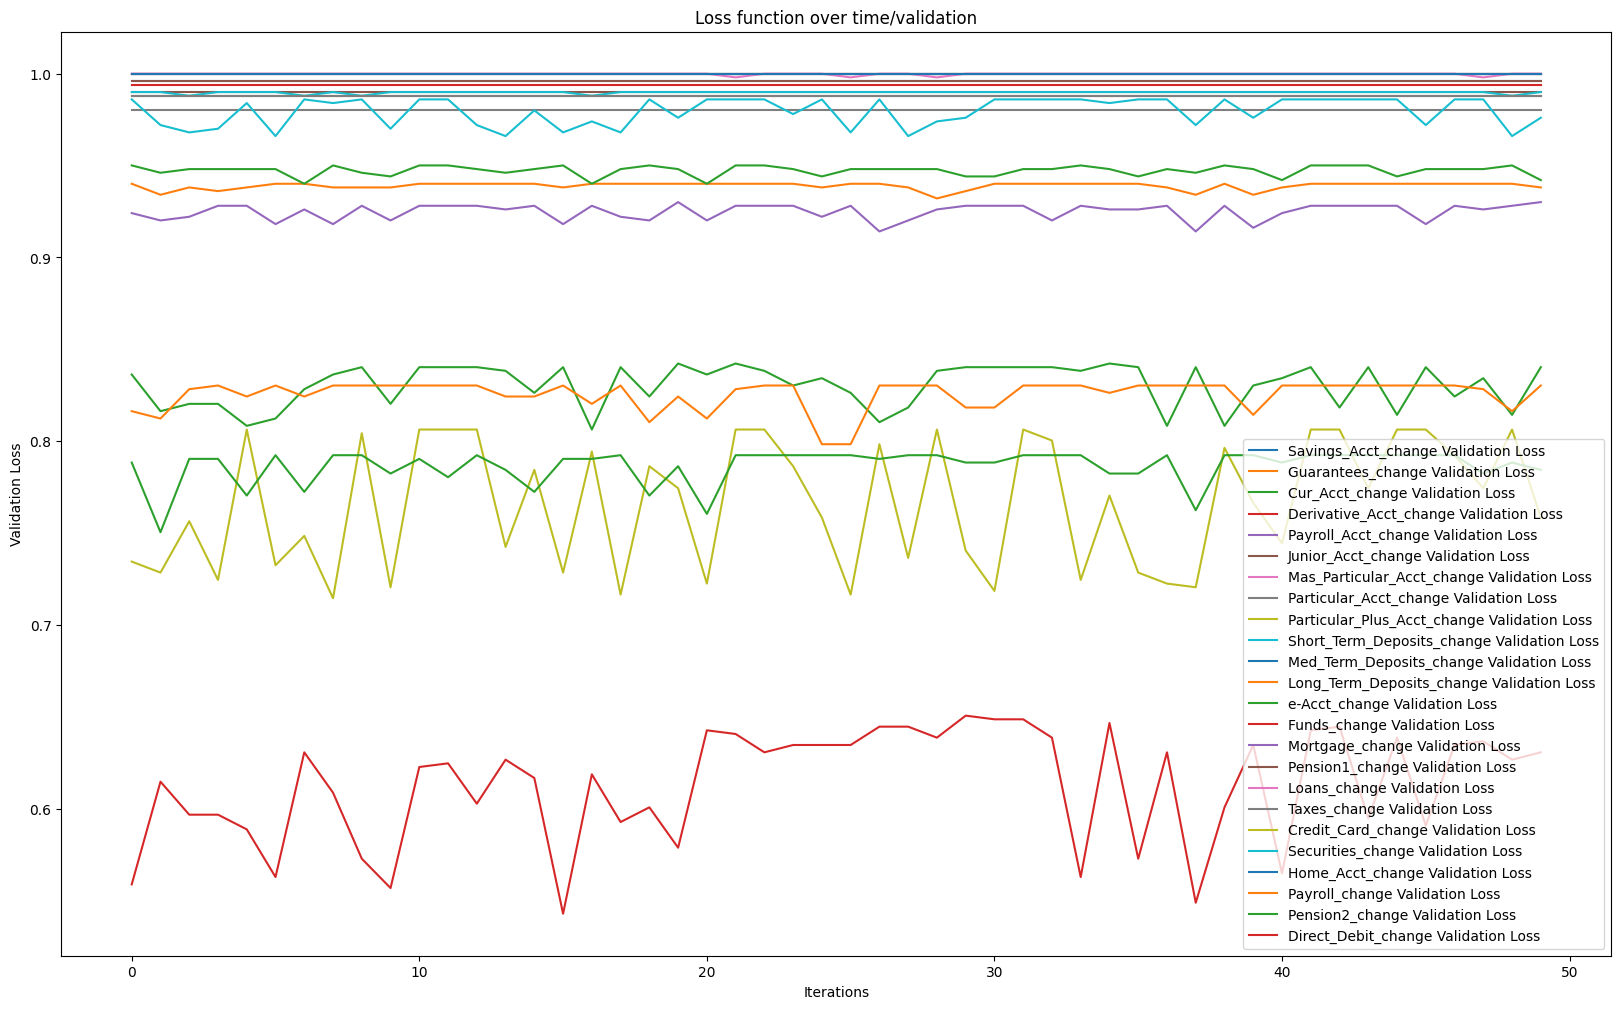

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
trained_models = {}
best_params = {}
evals_result_all = {}

for target_col in target_columns:
    print(f"Optimizing for target: {target_col}")
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, train_features, train_labels, val_features, val_labels, target_col), n_trials=50)
    best_params[target_col] = study.best_params
    final_model = lgb.LGBMClassifier(**best_params[target_col], verbose=-1)
    final_model.fit(train_features, train_labels[target_col])
    trained_models[target_col] = final_model
    evals_result_all[target_col] = study.trials_dataframe(attrs=('number', 'value', 'params'))

for target_col in target_columns:
    model = trained_models[target_col]
    y_val_pred = model.predict(val_features)
    plot_confusion_matrix_and_metrics(val_labels[target_col], y_val_pred, target_col)

plot_loss_function(evals_result_all)

100%|██████████| 314M/314M [00:10<00:00, 29.4MiB/s]
INFO:lightning_fabric.utilities.seed:Seed set to 12345678
INFO:lightning_fabric.utilities.seed:Seed set to 12345678
INFO:lightning_fabric.utilities.seed:Seed set to 12345678


  unique_id                  ds         y      ex_1      ex_2  ex_3     ex_4
0      HUFL 2016-07-01 00:00:00 -0.041413 -0.500000  0.166667  -0.5 -0.00137
1      HUFL 2016-07-01 00:15:00 -0.185467 -0.500000  0.166667  -0.5 -0.00137
2      HUFL 2016-07-01 00:30:00 -0.257495 -0.500000  0.166667  -0.5 -0.00137
3      HUFL 2016-07-01 00:45:00 -0.577510 -0.500000  0.166667  -0.5 -0.00137
4      HUFL 2016-07-01 01:00:00 -0.385501 -0.456522  0.166667  -0.5 -0.00137


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                     | Params | Mode 
-------------------------------------------------------------------
0 | loss          | MAE                      | 0      | train
1 | valid_loss    | MAE                      | 0      | train
2 | padder        | ConstantPad1d            | 0      | train
3 | scaler        | TemporalNorm             | 0      | train
4 | norm          | ReversibleInstanceNorm1d | 14     | train
5 | mixing_layers | Sequential               | 555 K  | train
6 | out           | Linear                   | 49.2 K | train
-------------------------------------------------------------------
605 K     Trainable params
0         Non-trainable params
605 K     Total params

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                | Type                     | Params | Mode 
--------------------------------------------------------------------------
0  | loss                | MAE                      | 0      | train
1  | valid_loss          | MAE                      | 0      | train
2  | padder              | ConstantPad1d            | 0      | train
3  | scaler              | TemporalNorm             | 0      | train
4  | norm                | ReversibleInstanceNorm1d | 14     | train
5  | temporal_projection | Linear                   | 49.2 K | train
6  | feature_mixer_hist  | FeatureMixing            | 21.1 K | train
7  | feature_mixer_futr  | FeatureMixing            | 20.2 K | train
8  | first_mixin

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type          | Params | Mode 
-----------------------------------------------------
0 | loss       | MAE           | 0      | train
1 | valid_loss | MAE           | 0      | train
2 | padder     | ConstantPad1d | 0      | train
3 | scaler     | TemporalNorm  | 0      | train
4 | mlp        | ModuleList    | 983 K  | train
5 | out        | Linear        | 172 K  | train
-----------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.625     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

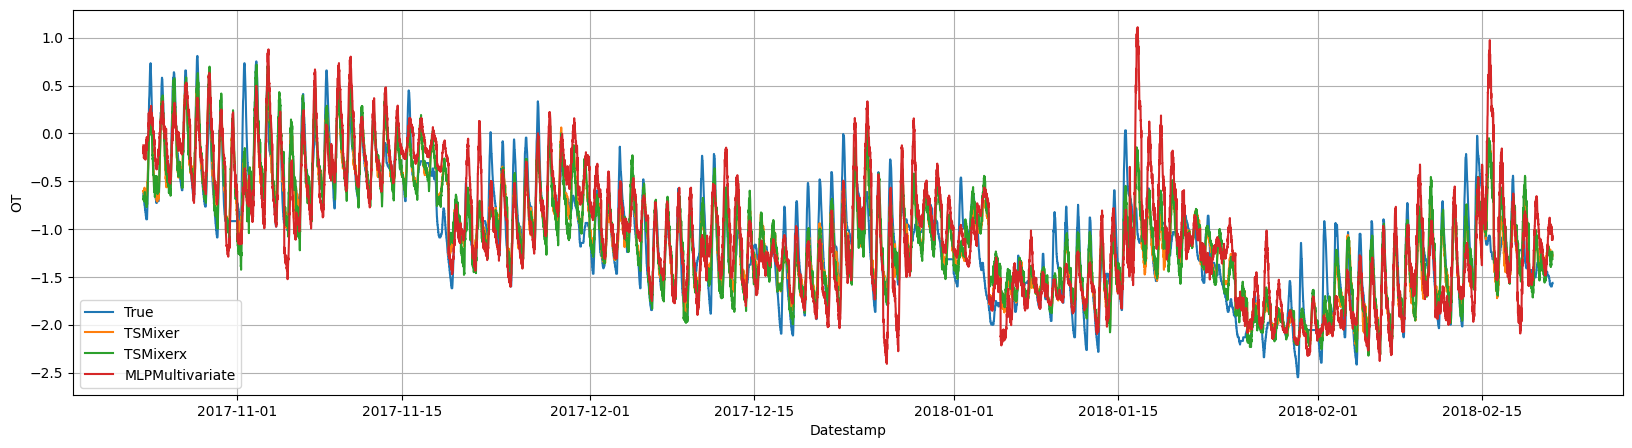

TSMixer horizon 96 - MAE: 0.250
TSMixer horizon 96 - MSE: 0.163
TSMixerx horizon 96 - MAE: 0.257
TSMixerx horizon 96 - MSE: 0.170
MLPMultivariate horizon 96 - MAE: 0.355
MLPMultivariate horizon 96 - MSE: 0.330


2024-09-10 06:40:39,417	INFO worker.py:1783 -- Started a local Ray instance.
2024-09-10 06:40:41,263	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2024-09-10_06-40-37   |
+--------------------------------------------------------------------+
| Search algorithm                 SearchGenerator                   |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 10                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2024-09-10_06-40-37
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-09-10_06-40-37_960760_3905/artifacts/2024-09-10_06-40-41/_train_tune_2024-09-10_06-40-37/driver_artifacts`


(_train_tune pid=84252) /usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=84252)   return torch.load

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=0, train_loss_step=0.244, train_loss_epoch=0.293]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=84252) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s, v_num=0, train_loss_step=0.271, train_loss_epoch=0.404, valid_loss=0.257]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=84252) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=0, train_loss_step=0.307, train_loss_epoch=0.323, valid_loss=0.244]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=84252) 
Epoch 399: 100%|██████████| 1/1 [00:01<00:00,  0.74it/s, v_num=0, train_loss_step=0.250, train_loss_epoch=0.270, valid_loss=0.240]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=84252) 
Validation DataLoader 

2024-09-10 06:48:38,500	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=84252) `Trainer.fit` stopped: `max_steps=500` reached.


(_train_tune pid=84252) 
Epoch 499: 100%|██████████| 1/1 [00:06<00:00,  0.15it/s, v_num=0, train_loss_step=0.262, train_loss_epoch=0.262, valid_loss=0.236]


(_train_tune pid=86323) /usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=86323)   return torch.load

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=0, train_loss_step=0.264, train_loss_epoch=0.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=86323) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=0, train_loss_step=0.285, train_loss_epoch=0.419, valid_loss=0.253]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=86323) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s, v_num=0, train_loss_step=0.325, train_loss_epoch=0.340, valid_loss=0.246]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=86323) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s, v_num=0, train_loss_step=0.272, train_loss_epoch=0.291, valid_loss=0.245]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [

2024-09-10 07:08:50,328	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=86323) 
Epoch 1299: 100%|██████████| 1/1 [00:09<00:00,  0.10it/s, v_num=0, train_loss_step=0.244, train_loss_epoch=0.244, valid_loss=0.235]


(_train_tune pid=91385) /usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=91385)   return torch.load

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
                                                                           
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s, v_num=0, train_loss_step=0.335, train_loss_epoch=0.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=91385) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s, v_num=0, train_loss_step=0.316, train_loss_epoch=0.476, valid_loss=0.254]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=91385) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=0, train_loss_step=0.340, train_loss_epoch=0.350, valid_loss=0.245]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=91385) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s, v_num=0, train_loss_ste

2024-09-10 07:39:44,976	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=91385) 
Epoch 1899: 100%|██████████| 1/1 [00:09<00:00,  0.10it/s, v_num=0, train_loss_step=0.253, train_loss_epoch=0.253, valid_loss=0.232]


(_train_tune pid=99063) /usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
(_train_tune pid=99063)   return torch.load

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s, v_num=0, train_loss_step=0.266, train_loss_epoch=0.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=99063) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s, v_num=0, train_loss_step=0.282, train_loss_epoch=0.417, valid_loss=0.264]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=99063) 
Epoch 203:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.280, train_loss_epoch=0.280, valid_loss=0.246]


2024-09-10 07:42:50,765	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-09-10 07:42:50,776	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2024-09-10_06-40-37' in 0.0090s.


Epoch 216:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.316, train_loss_epoch=0.316, valid_loss=0.246]


2024-09-10 07:43:00,787	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="/root/ray_results/_train_tune_2024-09-10_06-40-37", trainable=...)
2024-09-10 07:43:00,804	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- _train_tune_6067bd8b: FileNotFoundError('Could not fetch metrics for _train_tune_6067bd8b: both result.json and progress.csv were not found at /root/ray_results/_train_tune_2024-09-10_06-40-37/_train_tune_6067bd8b_5_dropout=0.1136,early_stop_patience_steps=5,ff_dim=64,h=96,input_size=512,learning_rate=0.0025,loss=ref_ph_d_2024-09-10_07-39-51')
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbac

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
Y_df, X_df, _ = LongHorizon.load(directory='./', group='ETTm2')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

X_df['ds'] = pd.to_datetime(X_df['ds'])
Y_df = Y_df.merge(X_df, on=['unique_id', 'ds'], how='left')

n_time = len(Y_df.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)

print(Y_df.head())

horizon = 96
input_size = 512

models = [
    TSMixer(h=horizon,
            input_size=input_size,
            n_series=7,
            max_steps=1000,
            val_check_steps=100,
            early_stop_patience_steps=5,
            scaler_type='identity',
            valid_loss=MAE(),
            random_seed=12345678,
           ),
    TSMixerx(h=horizon,
            input_size=input_size,
            n_series=7,
            max_steps=1000,
            val_check_steps=100,
            early_stop_patience_steps=5,
            scaler_type='identity',
            dropout=0.7,
            valid_loss=MAE(),
            random_seed=12345678,
            futr_exog_list=['ex_1', 'ex_2', 'ex_3', 'ex_4'],
           ),
    MLPMultivariate(h=horizon,
            input_size=input_size,
            n_series=7,
            max_steps=1000,
            val_check_steps=100,
            early_stop_patience_steps=5,
            scaler_type='standard',
            hidden_size=256,
            valid_loss=MAE(),
            random_seed=12345678,
           )
]

nf = NeuralForecast(models=models, freq='15min')
Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None)
Y_hat_df = Y_hat_df.reset_index()

Y_plot = Y_hat_df[Y_hat_df['unique_id'] == 'OT']
cutoffs = Y_hat_df['cutoff'].unique()[::horizon]
Y_plot = Y_plot[Y_plot['cutoff'].isin(cutoffs)]

plt.figure(figsize=(20,5))
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
for model in models:
    plt.plot(Y_plot['ds'], Y_plot[f'{model}'], label=f'{model}')
plt.xlabel('Datestamp')
plt.ylabel('OT')
plt.grid()
plt.legend()
plt.show()

from neuralforecast.losses.numpy import mse, mae

for model in models:
    mae_model = mae(Y_hat_df['y'], Y_hat_df[f'{model}'])
    mse_model = mse(Y_hat_df['y'], Y_hat_df[f'{model}'])
    print(f'{model} horizon {horizon} - MAE: {mae_model:.3f}')
    print(f'{model} horizon {horizon} - MSE: {mse_model:.3f}')

from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from neuralforecast.auto import AutoTSMixer, AutoTSMixerx

tsmixer_config = {
       "input_size": input_size,
       "max_steps": tune.choice([500, 1000, 2000]),
       "val_check_steps": 100,
       "early_stop_patience_steps": 5,
       "learning_rate": tune.loguniform(1e-4, 1e-2),
       "n_block": tune.choice([1, 2, 4, 6, 8]),
       "dropout": tune.uniform(0.0, 0.99),
       "ff_dim": tune.choice([32, 64, 128]),
       "scaler_type": 'identity',
    }

model = AutoTSMixer(h=horizon, n_series=7, loss=MAE(), config=tsmixer_config, num_samples=10, search_alg=HyperOptSearch(), backend='ray', valid_loss=MAE())
nf = NeuralForecast(models=[model], freq='15min')
Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None)


In [ ]:
# # Evaluation code
# for idx,col in enumerate(test_labels.columns):
#   cm = confusion_matrix(test_labels[col].values,yhat[:,idx])
#   cr = classification_report(test_labels[col].values,yhat[:,idx])
#   print(f"Label: {col} \nconf\n {cm}, \nreport\n {cr}\n")


What you can say about the results?

Model Explanation: The models (TSMixer, TSMixerx, MLPMultivariate) predict time-series data over a horizon of 96 future steps using features derived from historical patterns. Each model uses different neural architectures to capture relationships within multivariate time-series data for multiple output labels.

Analysis of Results:

TSMixer and TSMixerx perform better than MLPMultivariate, as seen from lower MAE (0.250 vs. 0.355) and MSE (0.163 vs. 0.330). While TSMixer and TSMixerx have similar performance, TSMixer slightly edges TSMixerx.
MAE (Mean Absolute Error) is suitable for measuring the average magnitude of errors, giving a clearer interpretation of actual prediction errors in real-world units. MSE (Mean Squared Error), which squares the error, penalizes large deviations more, highlighting extreme prediction errors. Both metrics are useful in multivariate label prediction for robust evaluation.
Monetization Insight: Implementing TSMixer can lead to immediate cost savings by reducing forecasting errors, thus avoiding overproduction or underutilization of resources, especially in operations where precise demand forecasting is critical.

# **Future Work:**
Given more time, I would explore different methods of blending, ensembling, or stacking models. Specifically, I would consider combining TSMixer models, which excel in handling time-series data, with LightGBM for a more robust, hybrid approach. This could improve the overall model performance, particularly in cases where LightGBM struggles with sparse data. Ensembling multiple models, such as TSMixer, LSTM, and LightGBM, could lead to better generalization and robustness, particularly for highly imbalanced or sparse datasets.

The LightGBM model alone, while effective for many columns, shows vulnerability in sparse features. This indicates the need for a more flexible approach, such as combining neural networks (TSMixer) with tree-based models (LightGBM), which may better handle temporal relationships and sparse columns, leading to more consistent and reliable predictions across all targets.

# This is it!
We hope you enjoyed this notebook.
Please share your thoughts and impressions, and send us a link to your notebook.
Talk to you soon:)